## Скачивание получившегося датасета из прошлой части

In [208]:
!pip -q install category-encoders optuna catboost

import sklearn
import pandas as pd
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from category_encoders.one_hot import OneHotEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.target_encoder import TargetEncoder

import optuna

from catboost import CatBoostRegressor

import torch

In [209]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [210]:
data = pd.read_csv('/content/drive/MyDrive/Diploma/preprocessed_small.csv', index_col=0)
data

class subject    2019_4    2019_5    2020_5    2020_6     4_dyn     5_dyn locality_type      population  correction  pupils_amount     district    target
login                                                                                                                                                                        
sch01110006_4_rus       4     rus  0.668860  0.710526  0.478070  0.489879 -0.190789 -0.220648          НПСТ         0-1.000           0            141          ЮФО  0.643725
sch01110012_4_rus       4     rus  0.597039  0.441729  0.466374  0.714035 -0.130665  0.272306          НПСТ         0-1.000           0            140          ЮФО  0.616228
sch01110019_4_rus       4     rus  0.554446  0.441520  0.535469  0.590226 -0.018977  0.148705          НПСТ    1.000-10.000           0            251          ЮФО  0.653110
sch01110024_4_rus       4     rus  0.742105  0.737817  0.613824  0.716303 -0.128282 -0.021514          НПСТ  10.000-100.000           0            896          ЮФО  0.731955
sch01110031_4_rus       4     rus  0.560150  0.675439  0.631579  0.708978  0.071429  0.033540          НПСТ    1.000-10.000           0            162          ЮФО  0.673375
...                   ...     ...       ...       ...       ...       ...       ...       ...           ...             ...         ...            ...          ...       ...
sch92120045_6_math      6    math  0.741045  0.556349  0.607576  0.565254 -0.133469  0.008905         Город        100.000+           0            772  Севастополь  0.422414
sch92120052_6_math      6    math  0.621429  0.522727  0.529545  0.346000 -0.091883 -0.176727          НПСТ    1.000-10.000           0            295  Севастополь  0.358333
sch92120059_6_math      6    math  0.470000  0.308621  0.495833  0.286000  0.025833 -0.022621          НПСТ    1.000-10.000           0            315  Севастополь  0.220690
sch92122004_6_math      6    math  0.680769  0.628571  0.562500  0.511111 -0.118269 -0.117460         Город        100.000+           0            114  Севастополь  0.288889
sch92126001_6_math      6    math  0.703289  0.605128  0.587736  0.553731 -0.115554 -0.051397         Город        100.000+           0           1085  Севастополь  0.491667

[38376 rows x 14 columns]

## Исследование данных

Сделаем признак класса категориальным

In [211]:
data['class'] = data['class'].astype(object)

Выделим категориальные колонки

In [212]:
categorical_columns = list(data.dtypes[data.dtypes == 'object'].index)
categorical_columns

['class', 'subject', 'locality_type', 'population', 'district']

Добавим ещё признаки класса и коррекции (это численный признак, его не надо кодировать, только посмотреть на распределение)

In [213]:
pseudo_categorical_columns = categorical_columns + ['correction']
pseudo_categorical_columns

['class', 'subject', 'locality_type', 'population', 'district', 'correction']

Посмотрим на распределение значений в них

In [214]:
def plot_categorical_columns_distribution(dataset, categorical_columns, amount):
    _, ax = plt.subplots(figsize=(15, 10), nrows=amount//2, ncols=2)
    for i in range(amount // 2):
        for j in range(2):
            statistics = dataset[categorical_columns[i * 2 + j]].value_counts()
            indices, values = list(statistics.index), list(statistics.values)
            if categorical_columns[i * 2 + j] != 'district':
                ax[i][j].pie(values, labels=indices, autopct=lambda x: round(len(dataset) * x / 100))
            else:
                ax[i][j].pie(values)
                labels = [index + ' (' + str(value) + ')' for index, value in zip(indices, values)]
                ax[i][j].legend(labels, loc='center right', bbox_to_anchor=(1, 0, (amount // 2) * 0.4 - 0.2, 1))
            ax[i][j].set_title(categorical_columns[i * 2 + j])
    plt.show()

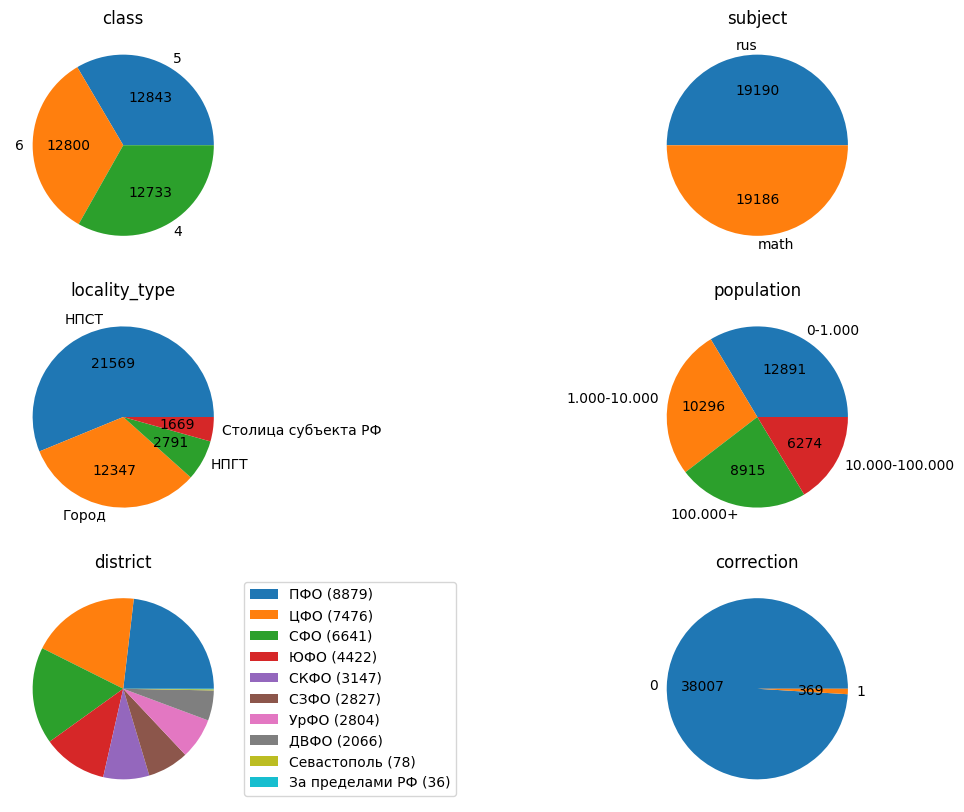

In [215]:
plot_categorical_columns_distribution(data, pseudo_categorical_columns, len(pseudo_categorical_columns))

Некоторые алгоритмы машинного обучения не работают с категориальными признаками, поэтому надо подумать, как их лучше закодировать

1) В колонке subject всего 2 признака, распределённых примерно одинаково, поэтому можно просто воспользоваться one-hot encoding-ом

2) У колонки population закодируем категории целыми числами - чем выше численность населения, тем больше получившееся число

3) У остальных признаков набор значений тоже, в целом, не велик, поэтому можно также попробовать one-hot encoding, хотя, в прочем, не стоит ограничиваться только им

Что касается численных колонок, то:

1) Классы распределены практически поровну - тут нечего и волноваться

2) А вот коррекционных школ критически мало - меньше 1% (возможно после формирования окончательных выборок, нужно будет переместить часть коррекционных школ в тренировочную)

## Разбиение датасета на тренировочную, валидационную и тестовую выборки

### Категориальные переменные

Попробуем разбить датасет пропорционально округам, потом каждый округ пропорционально численности населения, для этого надо, однако, составить датасет, в которым каждый логин - это школа (без предмета и класса)

Уберём признаки класса и субъекта

In [216]:
aux_data = data.drop(columns=['class', 'subject', 'target', '2019_4', '2019_5', '2020_5', '2020_6', '4_dyn', '5_dyn'])
aux_data

locality_type      population  correction  pupils_amount     district
login                                                                                   
sch01110006_4_rus           НПСТ         0-1.000           0            141          ЮФО
sch01110012_4_rus           НПСТ         0-1.000           0            140          ЮФО
sch01110019_4_rus           НПСТ    1.000-10.000           0            251          ЮФО
sch01110024_4_rus           НПСТ  10.000-100.000           0            896          ЮФО
sch01110031_4_rus           НПСТ    1.000-10.000           0            162          ЮФО
...                          ...             ...         ...            ...          ...
sch92120045_6_math         Город        100.000+           0            772  Севастополь
sch92120052_6_math          НПСТ    1.000-10.000           0            295  Севастополь
sch92120059_6_math          НПСТ    1.000-10.000           0            315  Севастополь
sch92122004_6_math         Город        100.000+           0            114  Севастополь
sch92126001_6_math         Город        100.000+           0           1085  Севастополь

[38376 rows x 5 columns]

Оставим только логин школы в качестве логина

In [217]:
aux_data.index = aux_data.reset_index()['login'].apply(lambda x: x[:11])
aux_data

locality_type      population  correction  pupils_amount     district
login                                                                            
sch01110006          НПСТ         0-1.000           0            141          ЮФО
sch01110012          НПСТ         0-1.000           0            140          ЮФО
sch01110019          НПСТ    1.000-10.000           0            251          ЮФО
sch01110024          НПСТ  10.000-100.000           0            896          ЮФО
sch01110031          НПСТ    1.000-10.000           0            162          ЮФО
...                   ...             ...         ...            ...          ...
sch92120045         Город        100.000+           0            772  Севастополь
sch92120052          НПСТ    1.000-10.000           0            295  Севастополь
sch92120059          НПСТ    1.000-10.000           0            315  Севастополь
sch92122004         Город        100.000+           0            114  Севастополь
sch92126001         Город        100.000+           0           1085  Севастополь

[38376 rows x 5 columns]

Оставим только уникальные колонки

In [218]:
aux_data = aux_data.reset_index().drop_duplicates().set_index('login')
aux_data

locality_type      population  correction  pupils_amount district
login                                                                               
sch01110006                 НПСТ         0-1.000           0            141      ЮФО
sch01110012                 НПСТ         0-1.000           0            140      ЮФО
sch01110019                 НПСТ    1.000-10.000           0            251      ЮФО
sch01110024                 НПСТ  10.000-100.000           0            896      ЮФО
sch01110031                 НПСТ    1.000-10.000           0            162      ЮФО
...                          ...             ...         ...            ...      ...
sch74146073                 НПСТ         0-1.000           0             66     УрФО
sch75153031                Город         0-1.000           0             96      СФО
sch77179462  Столица субъекта РФ        100.000+           0            387      ЦФО
sch86163002                 НПСТ         0-1.000           0             14     УрФО
sch11116052                 НПСТ         0-1.000           0             13     СЗФО

[6513 rows x 5 columns]

Не мешает ещё раз посмотреть на распределение колонок

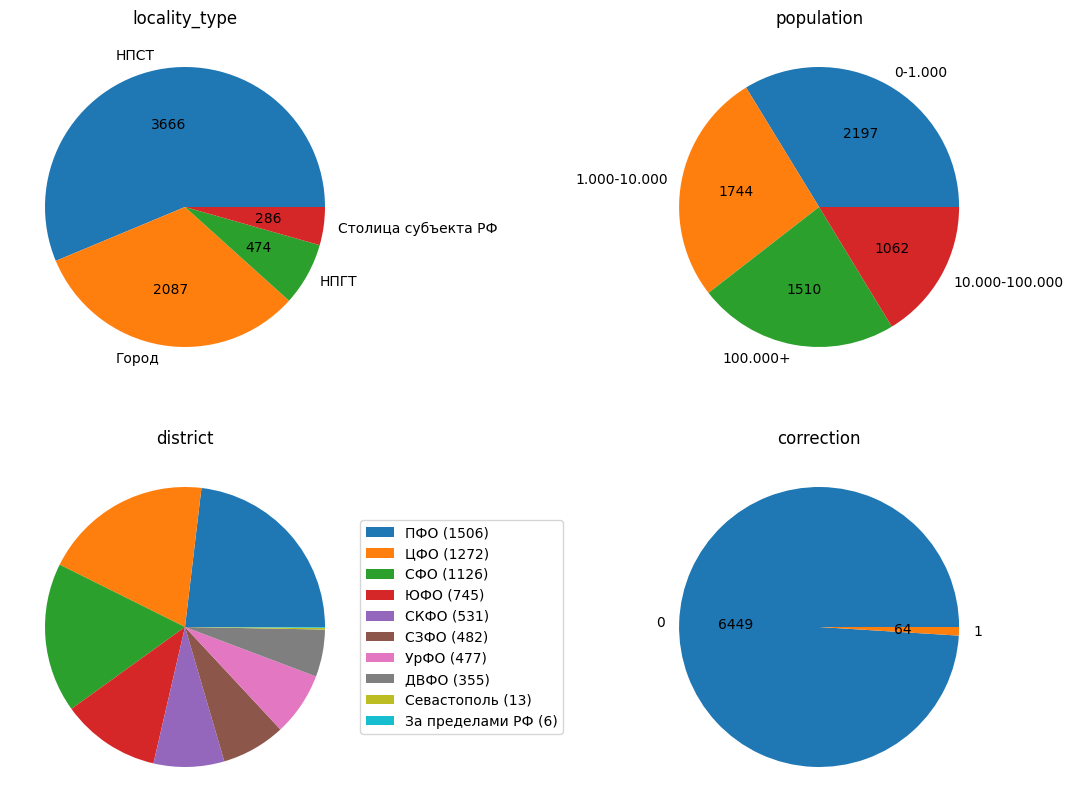

In [219]:
truncated_pseudo_categorical_columns = pseudo_categorical_columns.copy()
for column_to_delete in ['subject', 'class']:
    truncated_pseudo_categorical_columns.remove(column_to_delete)
plot_categorical_columns_distribution(aux_data, truncated_pseudo_categorical_columns, len(truncated_pseudo_categorical_columns))

Итак, получим список датасетов, где в каждом датасете значение округа будет уникальным

In [220]:
def get_datasets(dataset, column, target=None, columns_to_delete=None):
    unique = dataset[column].unique()
    unique.sort()
    datasets = [None for _ in range(len(unique))]
    if target is not None:
        targets = datasets.copy()
    for i in range(len(datasets)):
        indices = dataset[dataset[column] == unique[i]].index
        datasets[i] = dataset.loc[indices]
        if target is not None:
            targets[i] = target.loc[indices]
            datasets[i] = datasets[i].drop(columns=column)
        if columns_to_delete is not None:
            datasets[i] = datasets[i].drop(columns=columns_to_delete)

    if target is not None:
        return datasets, targets
    return datasets

In [221]:
datasets = get_datasets(aux_data, 'district')

Составим вспомогательные тренировочные, валидационные и тестовые выборки со седующими размерами выборок:

1) Тренировочная выборка составляет 75% от всей выборки

2) Валидационная выборка составляет 15% от всей выборки

3) Тестовая выборка составляет 10% от всей выборки

Посмотрим на севастопольские школы

In [222]:
datasets[6]

locality_type    population  correction  pupils_amount     district
login                                                                                 
sch92120004  Столица субъекта РФ      100.000+           0            879  Севастополь
sch92120009                Город      100.000+           0            781  Севастополь
sch92120014  Столица субъекта РФ      100.000+           0            776  Севастополь
sch92120019                Город      100.000+           0            722  Севастополь
sch92120025                Город      100.000+           0            645  Севастополь
sch92120030                Город      100.000+           0            842  Севастополь
sch92120035                Город      100.000+           0            731  Севастополь
sch92120040                Город      100.000+           0            424  Севастополь
sch92120045                Город      100.000+           0            772  Севастополь
sch92120052                 НПСТ  1.000-10.000           0            295  Севастополь
sch92120059                 НПСТ  1.000-10.000           0            315  Севастополь
sch92122004                Город      100.000+           0            114  Севастополь
sch92126001                Город      100.000+           0           1085  Севастополь

Они располагаются в одном городе, но тип населённого пункта у них разный, исправим это

In [223]:
datasets[6]['locality_type'] = 'Столица субъекта РФ'
datasets[6]['population'] = '100.000+'

Посмотрим, как стало

In [224]:
def make_datasets(datasets, stratified_columns=['population'], validation_and_test_size=0.25, test_size=0.4):
    train_datasets = [None for _ in range(len(datasets))]
    valid_datasets, test_datasets = train_datasets.copy(), train_datasets.copy()
    for i in range(len(datasets)):
        local_train, local_intermediate = train_test_split(datasets[i], test_size=validation_and_test_size, stratify=datasets[i][stratified_columns])
        train_datasets[i] = local_train
        local_valid, local_test = train_test_split(local_intermediate, test_size=test_size, stratify=local_intermediate[stratified_columns])
        valid_datasets[i] = local_valid
        test_datasets[i] = local_test

    train = pd.concat(train_datasets)
    valid = pd.concat(valid_datasets)
    test = pd.concat(test_datasets)
    return train, valid, test

In [225]:
aux_train, aux_valid, aux_test = make_datasets(datasets)

Снова проверим распределение переменных в датасете

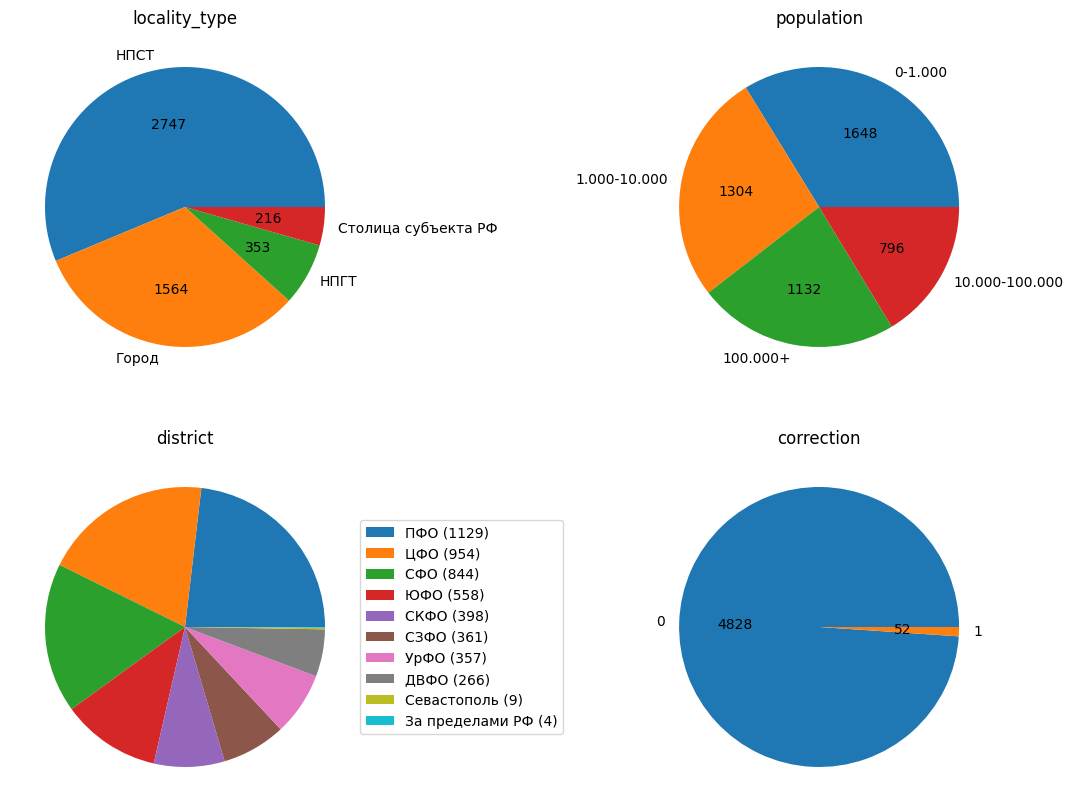

In [226]:
plot_categorical_columns_distribution(aux_train, truncated_pseudo_categorical_columns, len(truncated_pseudo_categorical_columns))

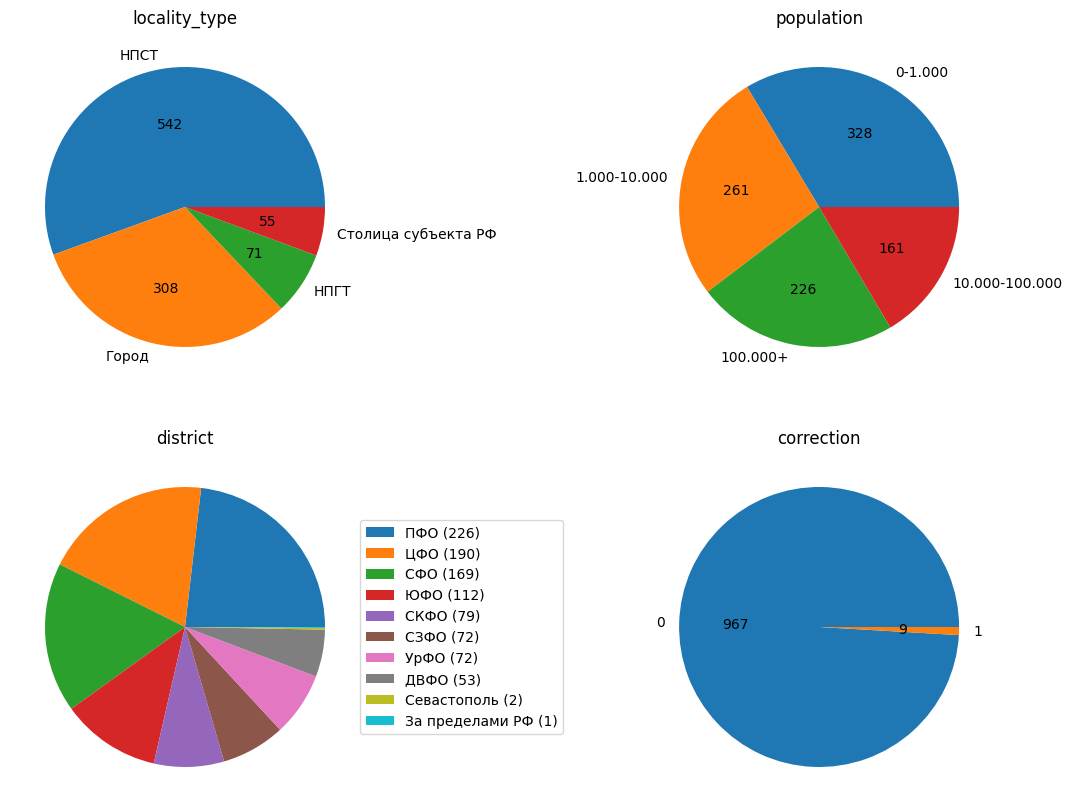

In [227]:
plot_categorical_columns_distribution(aux_valid, truncated_pseudo_categorical_columns, len(truncated_pseudo_categorical_columns))

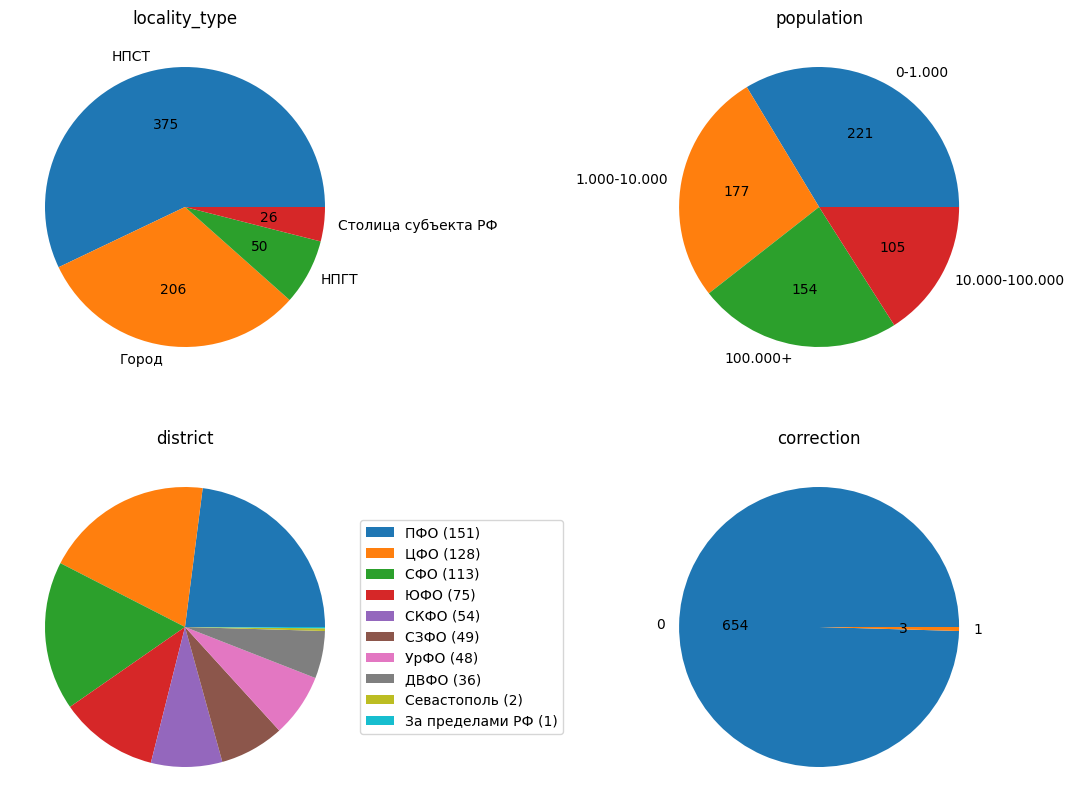

In [228]:
plot_categorical_columns_distribution(aux_test, truncated_pseudo_categorical_columns, len(truncated_pseudo_categorical_columns))

Что ж, видим, что распределние категориальных переменных очень хорошо сохранилось, сформируем окончательные выборки

In [229]:
train_schools, valid_schools, test_schools = set(aux_train.index), set(aux_valid.index), set(aux_test.index)
train, valid, test = data[data.index.str[:11].isin(train_schools)], data[data.index.str[:11].isin(valid_schools)], data[data.index.str[:11].isin(test_schools)]

Перемешаем датасеты

In [230]:
train, valid, test = train.sample(frac=1), valid.sample(frac=1), test.sample(frac=1)

Надо бы снова проверить распределение категориальных переменных

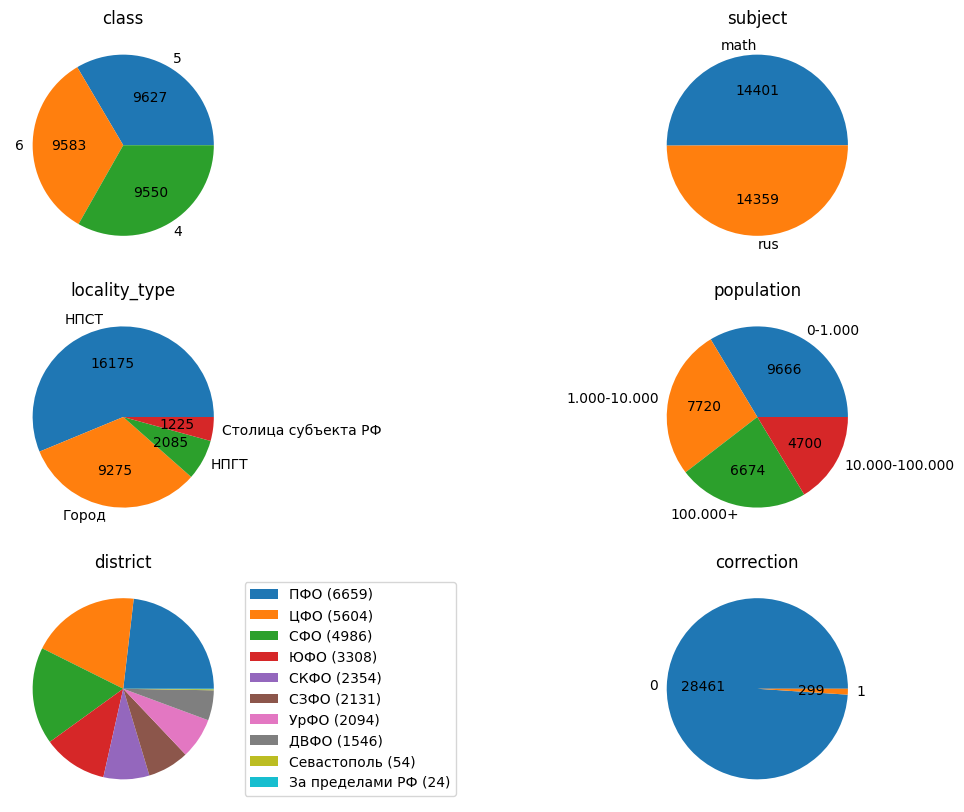

In [231]:
plot_categorical_columns_distribution(train, pseudo_categorical_columns, len(pseudo_categorical_columns))

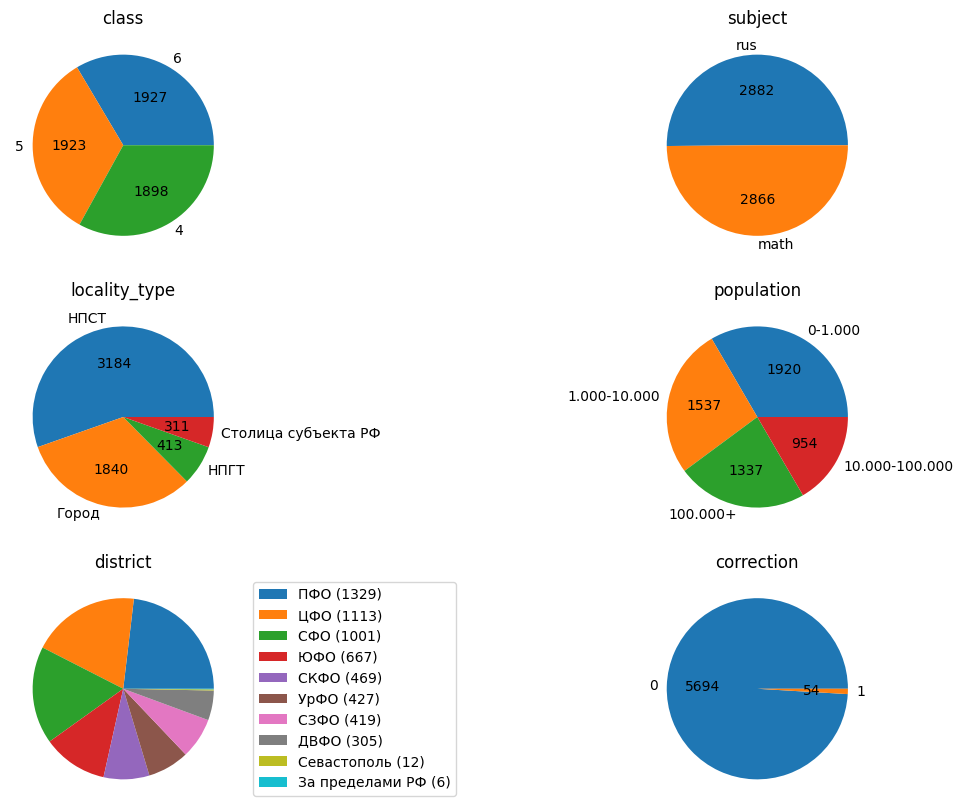

In [232]:
plot_categorical_columns_distribution(valid, pseudo_categorical_columns, len(pseudo_categorical_columns))

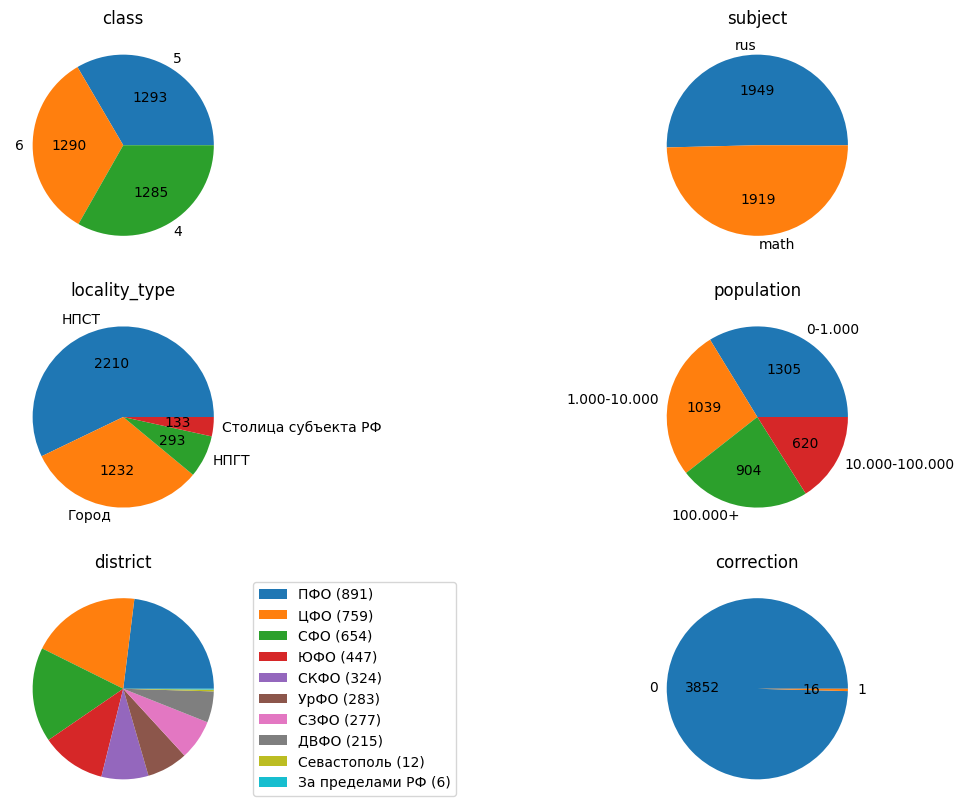

In [233]:
plot_categorical_columns_distribution(test, pseudo_categorical_columns, len(pseudo_categorical_columns))

Да, распределение также хорошо сохранилось

### Числовые переменные

Однако помимо категориальных переменных есть также и числовые - надо построить гистограммы для их значений и убедиться, что оно сохраняется

In [234]:
numerical_columns = list(data.dtypes[(data.dtypes == 'int64') | (data.dtypes == 'float64')].index)
numerical_columns.remove('correction')
numerical_columns

['2019_4',
 '2019_5',
 '2020_5',
 '2020_6',
 '4_dyn',
 '5_dyn',
 'pupils_amount',
 'target']

In [235]:
def plot_numerical_columns_distribution(mapping, numerical_columns):
    _, ax = plt.subplots(figsize=(25, 15), nrows=len(numerical_columns)//2, ncols=2)
    for i in range(len(numerical_columns) // 2):
        for j in range(2):
            for title, dataset in mapping.items():
                sns.kdeplot(dataset[numerical_columns[i * 2 + j]], ax=ax[i][j])
            ax[i][j].legend(list(mapping.keys()))
            ax[i][j].set_title(numerical_columns[i * 2 + j])
            ax[i][j].set_xlabel(None)
    plt.show()

Отрисуем графики плотности распределений численных признаков

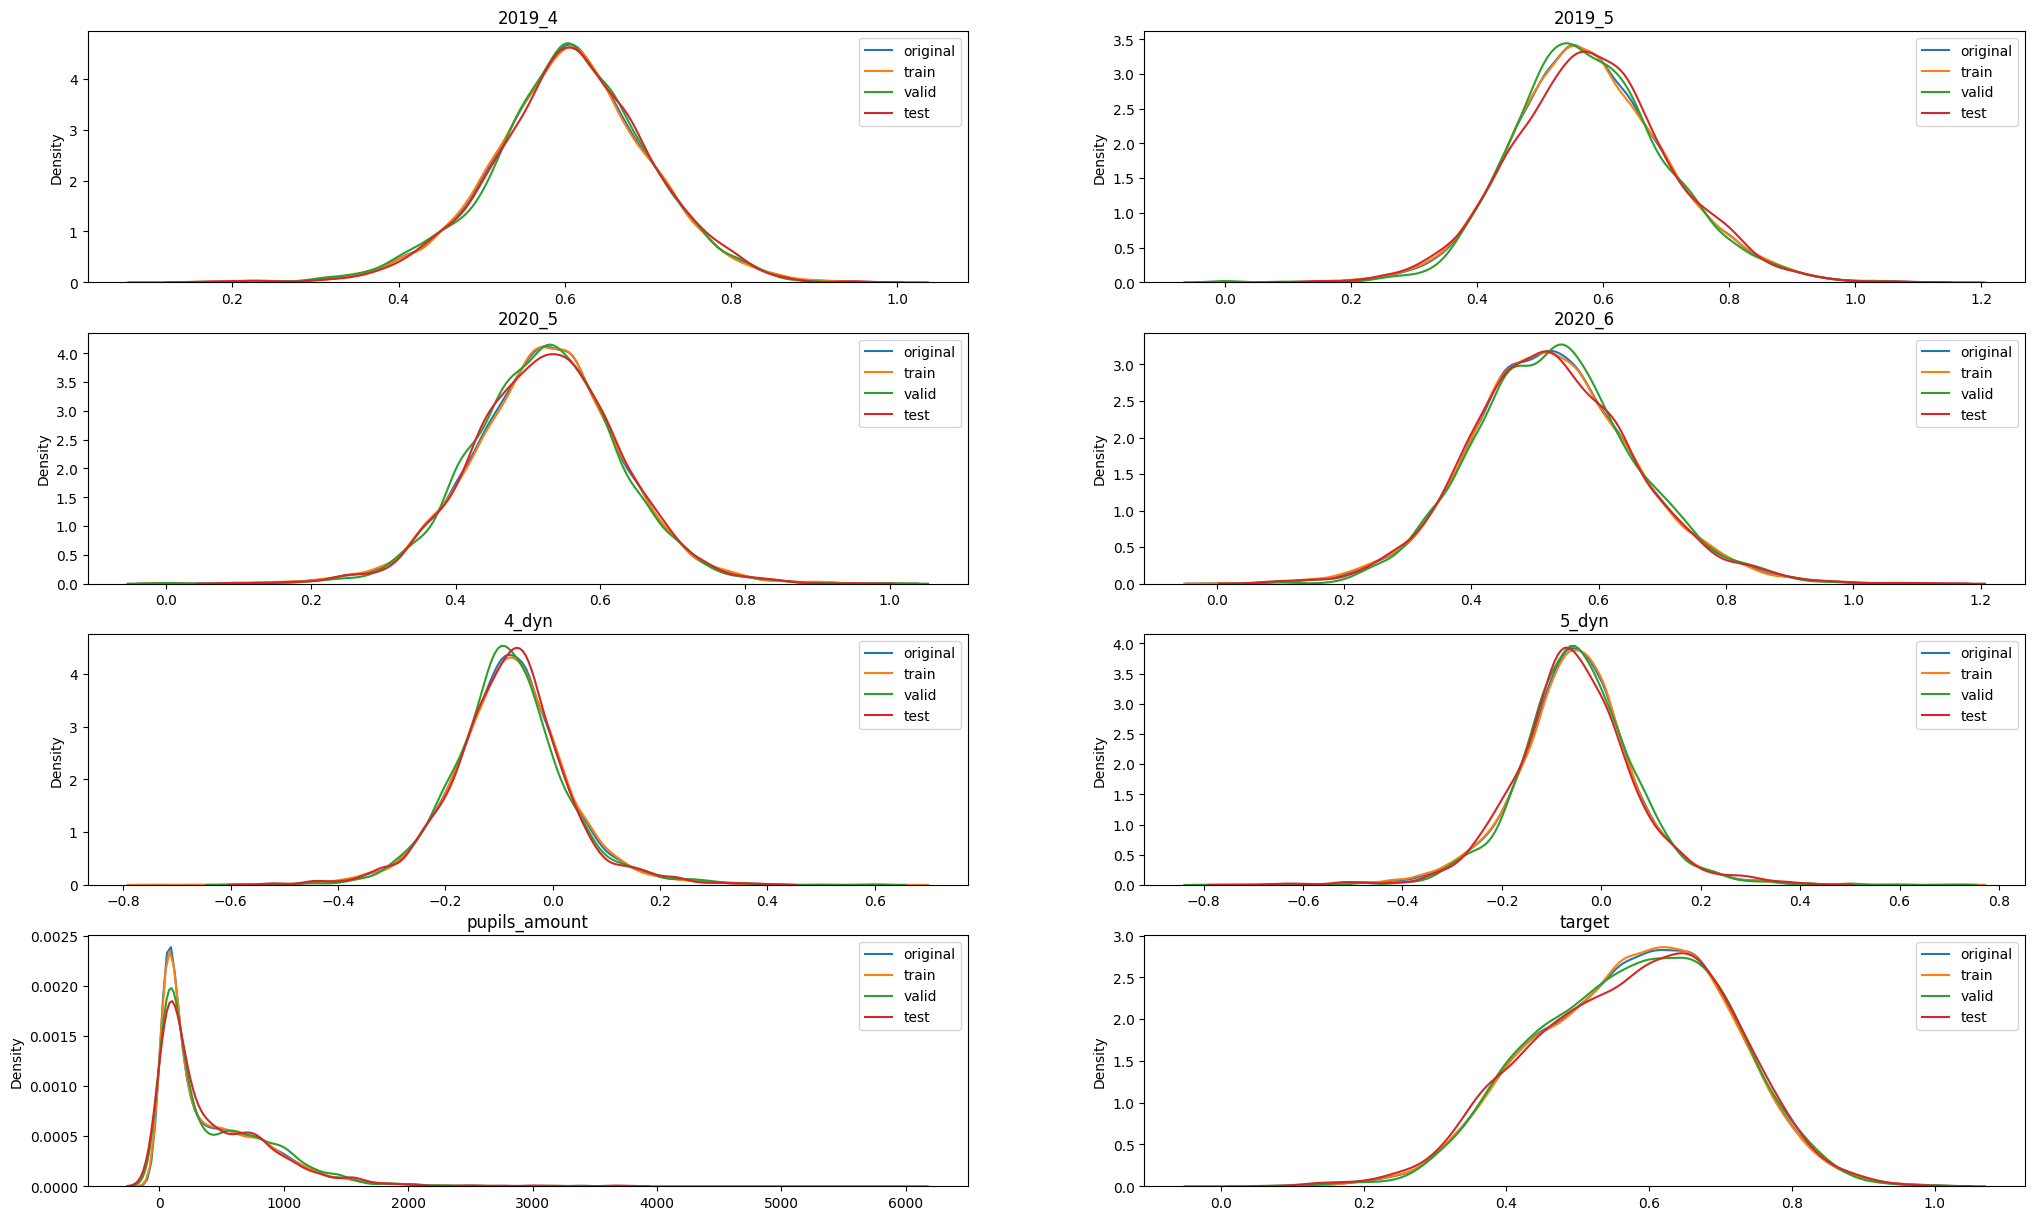

In [236]:
numerical_columns_mapping = {
    'original': data,
    'train': train,
    'valid': valid,
    'test': test
}
plot_numerical_columns_distribution(numerical_columns_mapping, numerical_columns)

Здесь тоже видим, что распределения идентичны, значит сохраняем получившиеся выборки



In [237]:
def get_features_and_targets(dataset, target_column):
    return dataset.drop(columns=target_column), dataset[target_column]

In [238]:
X_train, y_train = get_features_and_targets(train, 'target')
X_valid, y_valid = get_features_and_targets(valid, 'target')
X_test, y_test = get_features_and_targets(test, 'target')

## Обучение моделей машинного обучения

### Случайный лес

Создадим датафрейм для среднеквадратичных ошибок на тестовой выборке

In [239]:
random_forest_results = pd.DataFrame({
    'Модель': [],
    'MSE на тестовой выборке': []
})

#### Кодировка категориальных переменных и обучение модели на всей выборке

Случайный лес из sklearn не работает с категориальными переменными, поэтому попробуем их как-то закодировать

Закодируем колонки класса и предмета

In [240]:
def encode(dataframe, target, encoder, columns, on='login'):
    aux = encoder.transform(dataframe[columns], target)
    aux.index = dataframe.index
    return dataframe.drop(columns=columns).merge(aux, on=on)

In [241]:
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X_train[['subject', 'class']], y_train)
X_train_rf_inter = encode(X_train, y_train, one_hot_encoder, ['subject', 'class'])
X_valid_rf_inter = encode(X_valid, y_valid, one_hot_encoder, ['subject', 'class'])
X_test_rf_inter = encode(X_test, y_test, one_hot_encoder, ['subject', 'class'])

Закодируем population-колонку

In [242]:
unique_population = np.unique(X_train['population'].values)
population_mapping = dict(zip(unique_population, range(unique_population.shape[0])))

In [243]:
X_train_rf_inter['population'] = X_train_rf_inter['population'].apply(lambda x: population_mapping[x])
X_valid_rf_inter['population'] = X_valid_rf_inter['population'].apply(lambda x: population_mapping[x])
X_test_rf_inter['population'] = X_test_rf_inter['population'].apply(lambda x: population_mapping[x])

Далее мы будем использовать кодировщики, из которых нельзя будет вытащить имена переменных, поэтому нужно переименовать колонки некоторым образом, чтобы это можно было сделать

In [244]:
def rename_mapping(original_dataset, inter_dataset, columns_to_rename, mapping = {}):
    for column_to_rename in columns_to_rename:
        columns = inter_dataset.columns[inter_dataset.columns.str[:len(column_to_rename)] == column_to_rename]
        if len(columns) > 1:
            renamed = [column_to_rename + '_' + str(value) for value in original_dataset[column_to_rename].unique()]
            mapping = mapping | dict(zip(columns, renamed))
    return mapping

In [245]:
rename_columns_mapping = rename_mapping(X_train, X_train_rf_inter, ['subject', 'class'])

Посмотрим ещё раз на распределение целевой переменной на тренировочной выборке

In [246]:
y_train_rus, y_train_math = y_train[X_train[X_train['subject'] == 'rus'].index], y_train[X_train[X_train['subject'] == 'math'].index]

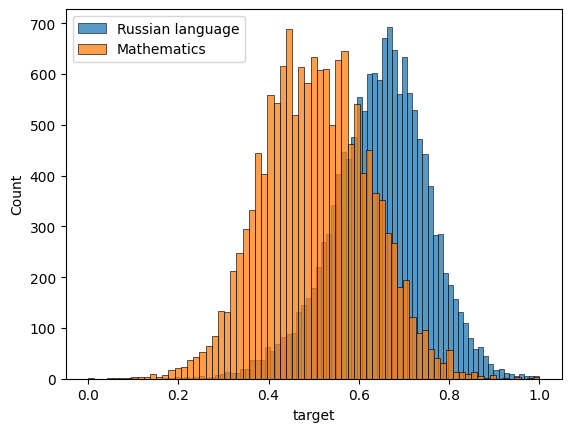

In [247]:
_, ax = plt.subplots()
sns.histplot(y_train_rus, ax=ax)
sns.histplot(y_train_math, ax=ax)
ax.legend(['Russian language', 'Mathematics'])
plt.show()

Оно бимодальное, а так как в датасете есть много строк, отличающихся друг от друга только классом и кодом предмета, модели будет сложнее делать предсказания

Попробуем отнормировать эту величину

In [248]:
def norm(column, mean, std):
    return (column - mean) / std

In [249]:
def denorm(column, mean, std):
    return column * std + mean

In [250]:
global_mean, global_std = y_train.mean(), y_train.std()

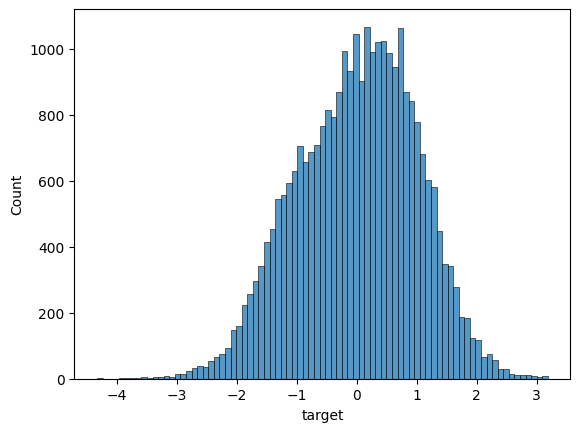

In [251]:
_, ax = plt.subplots()
sns.histplot(norm(y_train, global_mean, global_std), ax=ax)
plt.show()

Форма распределения изменилась (оно стало нормальном), и диапазон расширился

Также нормировка нужна, чтобы сравнивать результаты данной модели с последующими

Преобразуем же целевые переменные с помощью среднего и стандартного отклонения, рассчитанного по тренировочной выборке

In [252]:
y_train, y_valid, y_test = norm(y_train, global_mean, global_std), norm(y_valid, global_mean, global_std), norm(y_test, global_mean, global_std)

Остальные колонки преобразуем Target-encoding-ом

Среди всех остальных кодировщиков он был выбран, потому что в результате он не увеличивает число признаков, плюс в дополнение работает не хуже других (например One-hot-, или Helmert-кодировщиков)

In [253]:
remainds = [categorical_column for categorical_column in categorical_columns if categorical_column not in ['class', 'subject', 'population']]
target_encoder = TargetEncoder()
target_encoder.fit(X_train[remainds], y_train)
X_train_rf = encode(X_train_rf_inter, y_train, target_encoder, remainds)
X_valid_rf = encode(X_valid_rf_inter, y_valid, target_encoder, remainds)
X_test_rf = encode(X_test_rf_inter, y_test, target_encoder, remainds)

#### Обучение модели на всей выборке

##### Обучение лучшей модели с поиском лучших параметров с помощью библиотеки optuna

In [254]:
rename_columns_mapping = rename_mapping(X_train, X_train_rf, ['district', 'locality_type'], rename_columns_mapping)

Создадим функцию objective для поиска оптимальных гиперпараметров

In [255]:
linear_models_list = {
    'Lasso': Lasso,
    'Ridge': Ridge,
    'ElasticNet': ElasticNet
}

In [256]:
def objective(trial, params, model_name, metrics, X_train, y_train, X_valid, y_valid):
    keys, values = [], []
    for key, value in params.items():
        keys.append(key)
        if not isinstance(value, dict):
            values.append(value)
        elif value['type'] == 'categorical':
            values.append(trial.suggest_categorical(key, value['variants']))
        else:
            low, high, log = value['low'], value['high'], False
            if 'log' in value:
                log = value['log']
            if value['type'] == 'int':
                values.append(trial.suggest_int(key, low, high, log=log))
            elif value['type'] == 'float':
                values.append(trial.suggest_float(key, low, high, log=log))
    params = dict(zip(keys, values))
    if model_name is not None:
        model = model_name(**params)
    else:
        model = linear_models_list[params['model']](**{key: value for key, value in params.items() if key != 'model'})
    if isinstance(model, CatBoostRegressor):
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    else:
       model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return metrics(y_valid, preds)

In [257]:
random_forest_params = {
    'n_estimators': {
        'type': 'int',
        'low': 10,
        'high': 200,
        'log': True
    },
    'criterion': {
       'type': 'categorical',
       'variants': ['squared_error', 'friedman_mse']
    },
    'max_depth': {
        'type': 'int',
        'low': 2,
        'high': 20
    },
    'min_samples_split': {
        'type': 'int',
        'low': 2,
        'high': 10
    },
    'min_samples_leaf': {
        'type': 'int',
        'low': 1,
        'high': 10
    }
}

In [258]:
study_random_forest = optuna.create_study(direction='minimize', study_name='global_study_random_forest')
study_random_forest.optimize(lambda trial: objective(trial, random_forest_params, RandomForestRegressor, mean_squared_error, X_train_rf, y_train, X_valid_rf, y_valid), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:33:51,354] A new study created in memory with name: global_study_random_forest


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:34:17,797] Trial 0 finished with value: 0.3260598699675854 and parameters: {'n_estimators': 43, 'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.3260598699675854.
[I 2024-05-15 10:34:34,126] Trial 1 finished with value: 0.31844761594041154 and parameters: {'n_estimators': 76, 'criterion': 'friedman_mse', 'max_depth': 19, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.31844761594041154.
[I 2024-05-15 10:34:41,795] Trial 2 finished with value: 0.3204074194551587 and parameters: {'n_estimators': 32, 'criterion': 'squared_error', 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.31844761594041154.
[I 2024-05-15 10:34:43,619] Trial 3 finished with value: 0.338309465475024 and parameters: {'n_estimators': 22, 'criterion': 'squared_error', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 1 with val

In [259]:
best_random_forest = RandomForestRegressor(**study_random_forest.best_params)
best_random_forest.fit(X_train_rf, y_train)

RandomForestRegressor(criterion='friedman_mse', max_depth=9, min_samples_leaf=8,
                      min_samples_split=7, n_estimators=131)

In [260]:
global_random_forest_mse = mean_squared_error(y_test, best_random_forest.predict(X_test_rf))
random_forest_results = pd.concat((random_forest_results, pd.DataFrame([{'Модель': 'Случайный лес на всей выборке', 'MSE на тестовой выборке': global_random_forest_mse}])))
global_random_forest_mse

0.3464276640586012

Отрисуем график важности признаков в модели

In [261]:
def plot_feature_importances(model, mapping=rename_columns_mapping):
    numbers = None
    if 'sklearn.linear_model' in str(type(model)):
        numbers = model.coef_
    else:
        numbers = model.feature_importances_
    indices = numbers.argsort()[::-1]
    if isinstance(model, CatBoostRegressor):
        numbers /= 100
        original_feature_names = np.array(model.feature_names_)[indices]
    else:
        original_feature_names = model.feature_names_in_[indices]
    graphics = sns.barplot(numbers[indices], orient='h')
    renamed_columns = [mapping[column_name] if column_name in mapping else column_name for column_name in original_feature_names]
    graphics.set(yticklabels=renamed_columns)
    plt.show()

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


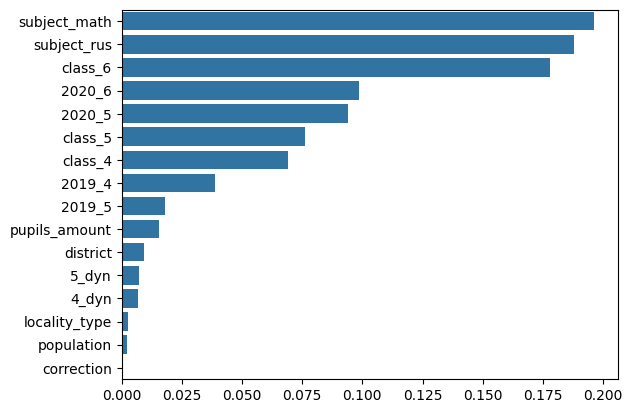

In [262]:
plot_feature_importances(best_random_forest)

Видим, что самый большие важности из признаков имеют коды предмета, потом идёт класс, и уже значительно меньше внимания случайный лес обращает на средние баллы по школам и количество учеников в них, у остальных же признаков влияние околонулевое

Ну и в целом видно, что случайному лесу здесь сложно выявлять какие-то зависимости, так как некоторые записи друг от друга отличаются только классом и предметом (именно эти признаки уменьшают энтропию в решающих деревьях)

Попробуем теперь другие стратегии - разделять выборку по предметам

#### Разделение выборки по предметам и обучение на них моделей

Вернём исходные значения целевых переменных в выборках

In [263]:
y_train, y_valid, y_test = denorm(y_train, global_mean, global_std), denorm(y_valid, global_mean, global_std), denorm(y_test, global_mean, global_std)

In [264]:
X_train_rf_subjects, y_train_subjects = get_datasets(X_train_rf, 'subject_1', y_train, ['subject_2'])
X_valid_rf_subjects, y_valid_subjects = get_datasets(X_valid_rf, 'subject_1', y_valid, ['subject_2'])
X_test_rf_subjects, y_test_subjects = get_datasets(X_test_rf, 'subject_1', y_test, ['subject_2'])

In [265]:
X_train_rf_rus, X_train_rf_math = X_train_rf_subjects[0], X_train_rf_subjects[1]
X_valid_rf_rus, X_valid_rf_math = X_valid_rf_subjects[0], X_valid_rf_subjects[1]
X_test_rf_rus, X_test_rf_math = X_test_rf_subjects[0], X_test_rf_subjects[1]

In [266]:
y_train_rus, y_train_math = y_train_subjects[0], y_train_subjects[1]
y_valid_rus, y_valid_math = y_valid_subjects[0], y_valid_subjects[1]
y_test_rus, y_test_math = y_test_subjects[0], y_test_subjects[1]

In [267]:
if X_train_rf_subjects[0].index[0][-1] == 'h':
    X_train_rf_rus, X_train_rf_math = X_train_rf_math, X_train_rf_rus
    y_train_rus, y_train_math = y_train_math, y_train_rus
    X_valid_rf_rus, X_valid_rf_math = X_valid_rf_math, X_valid_rf_rus
    y_valid_rus, y_valid_math = y_valid_math, y_valid_rus
    X_test_rf_rus, X_test_rf_math = X_test_rf_math, X_test_rf_rus
    y_test_rus, y_test_math = y_test_math, y_test_rus

##### Обучим модель предсказывать результаты по русскому языку и проинтерпретируем результаты

Точно также отнормируем целевую переменную для русского языка

In [268]:
y_train_rus_mean, y_train_rus_std = y_train_rus.mean(), y_train_rus.std()

In [269]:
y_train_rus = norm(y_train_rus, y_train_rus_mean, y_train_rus_std)
y_valid_rus = norm(y_valid_rus, y_train_rus_mean, y_train_rus_std)
y_test_rus = norm(y_test_rus, y_train_rus_mean, y_train_rus_std)

In [270]:
study_random_forest_rus = optuna.create_study(direction='minimize', study_name='study_rus_random_forest')
study_random_forest_rus.optimize(lambda trial: objective(trial, random_forest_params, RandomForestRegressor, mean_squared_error, X_train_rf_rus, y_train_rus, X_valid_rf_rus, y_valid_rus), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:39:42,135] A new study created in memory with name: study_rus_random_forest


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:39:46,971] Trial 0 finished with value: 0.5331574585229459 and parameters: {'n_estimators': 51, 'criterion': 'squared_error', 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5331574585229459.
[I 2024-05-15 10:39:50,797] Trial 1 finished with value: 0.5337634864682042 and parameters: {'n_estimators': 44, 'criterion': 'friedman_mse', 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.5331574585229459.
[I 2024-05-15 10:39:51,497] Trial 2 finished with value: 0.5562147912218663 and parameters: {'n_estimators': 16, 'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.5331574585229459.
[I 2024-05-15 10:40:13,219] Trial 3 finished with value: 0.5524080956971046 and parameters: {'n_estimators': 191, 'criterion': 'squared_error', 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value:

In [271]:
best_random_forest_rus = RandomForestRegressor(**study_random_forest_rus.best_params)
best_random_forest_rus.fit(X_train_rf_rus, y_train_rus)

RandomForestRegressor(max_depth=9, min_samples_leaf=10, min_samples_split=4,
                      n_estimators=103)

In [272]:
random_forest_rus_mse = mean_squared_error(y_test_rus, best_random_forest_rus.predict(X_test_rf_rus))
random_forest_results = pd.concat((random_forest_results, pd.DataFrame([{'Модель': 'Случайный лес, русский язык', 'MSE на тестовой выборке': random_forest_rus_mse}])))
random_forest_rus_mse

0.6027959673581941

In [273]:
random_forest_rus_predictions = pd.DataFrame({
    'login': X_test_rf_rus.index,
    'predictions': denorm(best_random_forest_rus.predict(X_test_rf_rus), y_train_rus_mean, y_train_rus_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


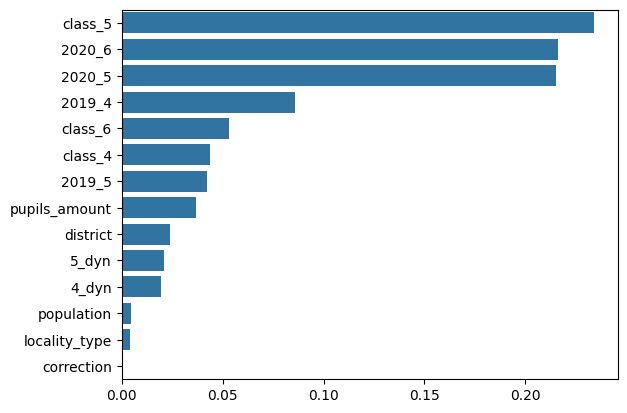

In [274]:
plot_feature_importances(best_random_forest_rus)

##### Обучим модель предсказывать результаты по математике и проинтерпретируем результаты

In [275]:
y_train_math_mean, y_train_math_std = y_train_math.mean(), y_train_math.std()

In [276]:
y_train_math = norm(y_train_math, y_train_math_mean, y_train_math_std)
y_valid_math = norm(y_valid_math, y_train_math_mean, y_train_math_std)
y_test_math = norm(y_test_math, y_train_math_mean, y_train_math_std)

In [277]:
study_random_forest_math = optuna.create_study(direction='minimize', study_name='study_math_random_forest')
study_random_forest_math.optimize(lambda trial: objective(trial, random_forest_params, RandomForestRegressor, mean_squared_error, X_train_rf_math, y_train_math, X_valid_rf_math, y_valid_math), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:41:55,986] A new study created in memory with name: study_math_random_forest


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:41:57,605] Trial 0 finished with value: 0.36739311153183085 and parameters: {'n_estimators': 14, 'criterion': 'friedman_mse', 'max_depth': 13, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.36739311153183085.
[I 2024-05-15 10:42:13,585] Trial 1 finished with value: 0.36541402916411014 and parameters: {'n_estimators': 153, 'criterion': 'friedman_mse', 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.36541402916411014.
[I 2024-05-15 10:42:14,363] Trial 2 finished with value: 0.35861884518141063 and parameters: {'n_estimators': 13, 'criterion': 'squared_error', 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.35861884518141063.
[I 2024-05-15 10:42:29,038] Trial 3 finished with value: 0.3590395527293861 and parameters: {'n_estimators': 179, 'criterion': 'friedman_mse', 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 6}. Best is trial 2 wit

In [278]:
best_random_forest_math = RandomForestRegressor(**study_random_forest_math.best_params)
best_random_forest_math.fit(X_train_rf_math, y_train_math)

RandomForestRegressor(max_depth=7, min_samples_leaf=5, min_samples_split=5,
                      n_estimators=101)

In [279]:
random_forest_math_mse = mean_squared_error(y_test_math, best_random_forest_math.predict(X_test_rf_math))
random_forest_results = pd.concat((random_forest_results, pd.DataFrame([{'Модель': 'Случайный лес, математика', 'MSE на тестовой выборке': random_forest_math_mse}])))
random_forest_math_mse

0.3837080035246085

In [280]:
random_forest_math_predictions = pd.DataFrame({
    'login': X_test_rf_math.index,
    'predictions': denorm(best_random_forest_math.predict(X_test_rf_math), y_train_math_mean, y_train_math_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


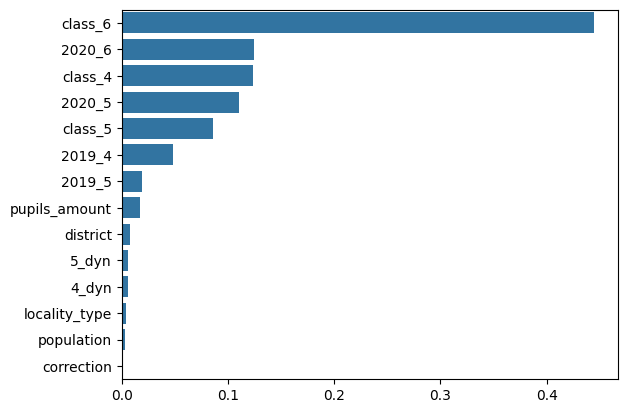

In [281]:
plot_feature_importances(best_random_forest_math)

##### Теперь посчитаем MSE на всей выборке с использованием обученных моделей на выборках  с русским языком и математикой

In [282]:
random_forest_predictions = pd.concat((random_forest_rus_predictions, random_forest_math_predictions))
random_forest_predictions

predictions
login                          
sch33133202_5_rus      0.629738
sch59193506_6_rus      0.706918
sch59193293_5_rus      0.539455
sch54140007_5_rus      0.542494
sch66160168_4_rus      0.668768
...                         ...
sch35156065_5_math     0.493147
sch02123477_6_math     0.414047
sch50103084_6_math     0.450083
sch67173007_6_math     0.486257
sch08180084_4_math     0.576062

[3868 rows x 1 columns]

In [283]:
random_forest_predictions['predictions'] = norm(random_forest_predictions['predictions'], global_mean, global_std)

Отнормируем данные обратно

In [284]:
y_train, y_valid, y_test = norm(y_train, global_mean, global_std), norm(y_valid, global_mean, global_std), norm(y_test, global_mean, global_std)

Посчитаем среднеквадратичную ошибку на всей выборке с помощью моделей, обученных на выборках по русскому языку и математике

In [285]:
random_forest_mixed_mse = mean_squared_error(y_test.loc[random_forest_predictions.index], random_forest_predictions['predictions'])
random_forest_results = pd.concat((random_forest_results, pd.DataFrame([{'Модель': 'Случайный лес, русский язык + математика', 'MSE на тестовой выборке': random_forest_mixed_mse}])))
random_forest_mixed_mse

0.3468535518884598

##### Общие выводы

Как и ожидалось, модели, разделённые по предметам, обращают самое большое внимание на класс, средние баллы и количество учеников в школах

Результаты получились хуже результатов на всей выборке, так как довольно много строк различаются только по классам

Однако если сделать предсказания с помощью 2 моделей для всей выборки, то итоговая ошибка уменьшается на несколько тысячных

#### Общие выводы по случайному лесу

In [286]:
random_forest_results = random_forest_results.set_index('Модель')
random_forest_results

MSE на тестовой выборке
Модель                                                           
Случайный лес на всей выборке                            0.346428
Случайный лес, русский язык                              0.602796
Случайный лес, математика                                0.383708
Случайный лес, русский язык + математика                 0.346854

То есть можно сделать вывод, что если использовать случайный лес для решения этой задачи, то либо нужно обучать модель на всей выборке, либо разбивать выборку по классам, для каждого класса обучать свою модель, а адлее делать предсказания на всей тестовой выборке

### Градиентный бустинг

Есть, однако, ансамблевый алгоритм на решающих деревьях, который мощнее, чем случайный лес и на данный момент составляет конкуренцию нейросетевым подходам в реальных задачах - градиентный бустинг

Подготовим датасеты

In [287]:
X_train_cb, X_valid_cb, X_test_cb = X_train.copy(), X_valid.copy(), X_test.copy()

In [288]:
X_train_cb['population'] = X_train_cb['population'].apply(lambda x: population_mapping[x])
X_valid_cb['population'] = X_valid_cb['population'].apply(lambda x: population_mapping[x])
X_test_cb['population'] = X_test_cb['population'].apply(lambda x: population_mapping[x])

In [289]:
categorical_columns.remove('population')

Создадим датасеты для среднеквадратичных ошибок на тестовой выборке

In [290]:
catboost_results = pd.DataFrame({
    'Модель': [],
    'MSE на тестовой выборке': []
})

#### Обучение модели на всей выборке

Создадим словарь с параметрами по умолчанию

In [291]:
default_catboost_params = {
    'cat_features': categorical_columns,
    'eval_metric': 'RMSE',
    'grow_policy': 'Lossguide',
    'use_best_model': True,
    'verbose': False
}

In [292]:
catboost_params = {
    'n_estimators': {
        'type': 'int',
        'low': 100,
        'high': 1000
    },
    'l2_leaf_reg': {
        'type': 'float',
        'low': 0.25,
        'high': 5,
    },
    'max_depth': {
       'type': 'int',
       'low': 2,
       'high': 20,
       'log': True
    },
    'max_leaves': {
        'type': 'int',
        'low': 2,
        'high': 64,
        'log': True
    }
}
catboost_params.update(default_catboost_params)

In [293]:
study_catboost = optuna.create_study(direction='minimize', study_name='global_study_catboost')
study_catboost.optimize(lambda trial: objective(trial, catboost_params, CatBoostRegressor, mean_squared_error, X_train_cb, y_train, X_valid_cb, y_valid), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:44:05,470] A new study created in memory with name: global_study_catboost


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:44:24,496] Trial 0 finished with value: 0.31261735103450966 and parameters: {'n_estimators': 565, 'l2_leaf_reg': 4.75697101384326, 'max_depth': 15, 'max_leaves': 9}. Best is trial 0 with value: 0.31261735103450966.
[I 2024-05-15 10:44:31,847] Trial 1 finished with value: 0.3870821135060545 and parameters: {'n_estimators': 645, 'l2_leaf_reg': 1.0863061019274944, 'max_depth': 16, 'max_leaves': 3}. Best is trial 0 with value: 0.31261735103450966.
[I 2024-05-15 10:44:41,783] Trial 2 finished with value: 0.3119235017861175 and parameters: {'n_estimators': 185, 'l2_leaf_reg': 2.0906687457894453, 'max_depth': 16, 'max_leaves': 39}. Best is trial 2 with value: 0.3119235017861175.
[I 2024-05-15 10:44:47,155] Trial 3 finished with value: 0.5350034478340877 and parameters: {'n_estimators': 583, 'l2_leaf_reg': 4.78029594332737, 'max_depth': 6, 'max_leaves': 2}. Best is trial 2 with value: 0.3119235017861175.
[I 2024-05-15 10:44:48,726] Trial 4 finished with value: 0.43599827126432

In [294]:
best_catboost = CatBoostRegressor(**study_catboost.best_params, **default_catboost_params)
best_catboost.fit(X_train_cb, y_train, eval_set=[(X_valid_cb, y_valid)])

In [295]:
global_catboost_mse = mean_squared_error(y_test, best_catboost.predict(X_test_cb))
catboost_results = pd.concat((catboost_results, pd.DataFrame([{'Модель': 'Градиентный бустинг на всей выборке', 'MSE на тестовой выборке': global_catboost_mse}])))
global_catboost_mse

0.33920809060709695

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


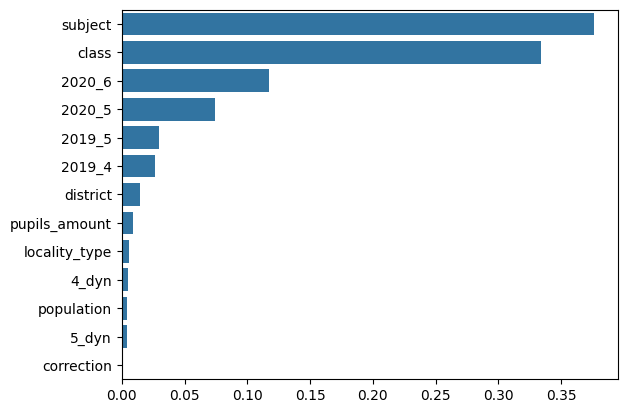

In [296]:
plot_feature_importances(best_catboost)

А вот и отличие от модели случайного леса (любой, что мы использовали ранее) - граиентный бустинг обращает очень сильное внимание на признак предмета, а вот на округа и количество учеников в школах практически нет

Качество примерно на 2 сотых хуже по сравнению со случайным лесом

#### Разделение выборки по предметам и обучение на них моделей

Получим нужные выборки

In [297]:
X_train_cb_subjects = get_datasets(X_train_cb, 'subject', columns_to_delete=['subject'])
X_valid_cb_subjects = get_datasets(X_valid_cb, 'subject', columns_to_delete=['subject'])
X_test_cb_subjects = get_datasets(X_test_cb, 'subject', columns_to_delete=['subject'])

In [298]:
X_train_cb_rus, X_train_cb_math = X_train_cb_subjects[0], X_train_cb_subjects[1]
X_valid_cb_rus, X_valid_cb_math = X_valid_cb_subjects[0], X_valid_cb_subjects[1]
X_test_cb_rus, X_test_cb_math = X_test_cb_subjects[0], X_test_cb_subjects[1]

In [299]:
if X_train_cb_rus.index[0][-1] == 'h':
    X_train_cb_rus, X_train_cb_math = X_train_cb_math, X_train_cb_rus
    X_valid_cb_rus, X_valid_cb_math = X_valid_cb_math, X_valid_cb_rus
    X_test_cb_rus, X_test_cb_math = X_test_cb_math, X_test_cb_rus

In [300]:
catboost_params['cat_features'].remove('subject')

##### Обучим модель предсказывать результаты по русскому языку и проинтерпретируем результаты

In [301]:
study_catboost_rus = optuna.create_study(direction='minimize', study_name='study_rus_catboost')
study_catboost_rus.optimize(lambda trial: objective(trial, catboost_params, CatBoostRegressor, mean_squared_error, X_train_cb_rus, y_train_rus, X_valid_cb_rus, y_valid_rus), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:47:59,866] A new study created in memory with name: study_rus_catboost


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:48:00,898] Trial 0 finished with value: 0.5707428522259236 and parameters: {'n_estimators': 148, 'l2_leaf_reg': 3.0311901700098507, 'max_depth': 2, 'max_leaves': 5}. Best is trial 0 with value: 0.5707428522259236.
[I 2024-05-15 10:48:02,713] Trial 1 finished with value: 0.5653367171641669 and parameters: {'n_estimators': 257, 'l2_leaf_reg': 1.6236621045170512, 'max_depth': 18, 'max_leaves': 3}. Best is trial 1 with value: 0.5653367171641669.
[I 2024-05-15 10:48:09,031] Trial 2 finished with value: 0.5391866101270352 and parameters: {'n_estimators': 622, 'l2_leaf_reg': 4.832285633121581, 'max_depth': 2, 'max_leaves': 10}. Best is trial 2 with value: 0.5391866101270352.
[I 2024-05-15 10:48:24,063] Trial 3 finished with value: 0.5241180451848326 and parameters: {'n_estimators': 823, 'l2_leaf_reg': 4.718617399847509, 'max_depth': 5, 'max_leaves': 46}. Best is trial 3 with value: 0.5241180451848326.
[I 2024-05-15 10:48:33,455] Trial 4 finished with value: 0.5293230183081916

In [302]:
best_catboost_rus = CatBoostRegressor(**study_catboost_rus.best_params, **default_catboost_params)
best_catboost_rus.fit(X_train_cb_rus, y_train_rus, eval_set=[(X_valid_cb_rus, y_valid_rus)])

In [303]:
catboost_rus_mse = mean_squared_error(y_test_rus, best_catboost_rus.predict(X_test_cb_rus))
catboost_results = pd.concat((catboost_results, pd.DataFrame([{'Модель': 'Градиентный бустинг, русский язык', 'MSE на тестовой выборке': catboost_rus_mse}])))
catboost_rus_mse

0.5949261623812647

In [304]:
catboost_rus_predictions = pd.DataFrame({
    'login': X_test_cb_rus.index,
    'predictions': denorm(best_catboost_rus.predict(X_test_cb_rus), y_train_rus_mean, y_train_rus_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


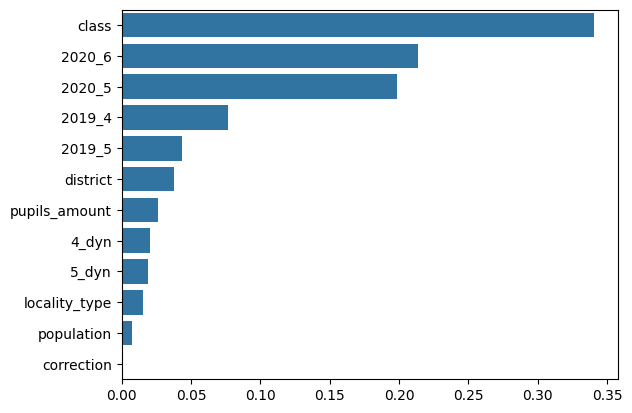

In [305]:
plot_feature_importances(best_catboost_rus)

##### Обучим модель предсказывать результаты по математике и проинтерпретируем результаты

In [306]:
study_catboost_math = optuna.create_study(direction='minimize', study_name='study_math_catboost')
study_catboost_math.optimize(lambda trial: objective(trial, catboost_params, CatBoostRegressor, mean_squared_error, X_train_cb_math, y_train_math, X_valid_cb_math, y_valid_math), n_trials=20,
               show_progress_bar=True)

[I 2024-05-15 10:51:38,790] A new study created in memory with name: study_math_catboost


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-05-15 10:51:43,465] Trial 0 finished with value: 0.35776187281657407 and parameters: {'n_estimators': 770, 'l2_leaf_reg': 1.6391326489477778, 'max_depth': 2, 'max_leaves': 15}. Best is trial 0 with value: 0.35776187281657407.
[I 2024-05-15 10:51:45,965] Trial 1 finished with value: 0.36191091703931344 and parameters: {'n_estimators': 410, 'l2_leaf_reg': 4.881458134536178, 'max_depth': 2, 'max_leaves': 30}. Best is trial 0 with value: 0.35776187281657407.
[I 2024-05-15 10:52:03,149] Trial 2 finished with value: 0.3478293053562588 and parameters: {'n_estimators': 590, 'l2_leaf_reg': 4.195885657875358, 'max_depth': 6, 'max_leaves': 33}. Best is trial 2 with value: 0.3478293053562588.
[I 2024-05-15 10:52:09,593] Trial 3 finished with value: 0.35802107852392845 and parameters: {'n_estimators': 743, 'l2_leaf_reg': 4.113641484052019, 'max_depth': 2, 'max_leaves': 6}. Best is trial 2 with value: 0.3478293053562588.
[I 2024-05-15 10:52:14,217] Trial 4 finished with value: 0.357949817662

In [307]:
best_catboost_math = CatBoostRegressor(**study_catboost_math.best_params, **default_catboost_params)
best_catboost_math.fit(X_train_cb_math, y_train_math, eval_set=[(X_valid_cb_math, y_valid_math)])

In [308]:
catboost_math_mse = mean_squared_error(y_test_math, best_catboost_math.predict(X_test_cb_math))
catboost_results = pd.concat((catboost_results, pd.DataFrame([{'Модель': 'Градиентный бустинг, математика', 'MSE на тестовой выборке': catboost_math_mse}])))
catboost_math_mse

0.37238151719848894

In [309]:
catboost_math_predictions = pd.DataFrame({
    'login': X_test_cb_math.index,
    'predictions': denorm(best_catboost_math.predict(X_test_cb_math), y_train_math_mean, y_train_math_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


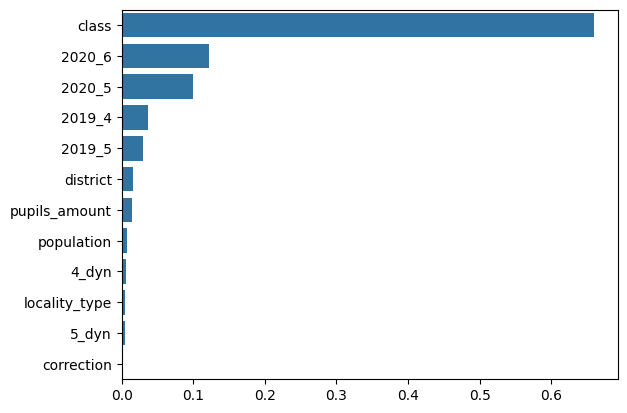

In [310]:
plot_feature_importances(best_catboost_math)

Так как признака предмета нет, модели обращают самое большое внимание на признак класса, потом ужеследуют средние баллы

Здесь ещё также признаки округа и количества учеников в школе имеют какой-никакой вес

##### Теперь посчитаем MSE на всей выборке с использованием обученных моделей на выборках  с русским языком и математикой

In [311]:
catboost_predictions = pd.concat((catboost_rus_predictions, catboost_math_predictions))
catboost_predictions

predictions
login                          
sch33133202_5_rus      0.632619
sch59193506_6_rus      0.710168
sch59193293_5_rus      0.538648
sch54140007_5_rus      0.535107
sch66160168_4_rus      0.649371
...                         ...
sch35156065_5_math     0.501376
sch02123477_6_math     0.415524
sch50103084_6_math     0.453049
sch67173007_6_math     0.484317
sch08180084_4_math     0.580873

[3868 rows x 1 columns]

In [312]:
catboost_predictions['predictions'] = norm(catboost_predictions['predictions'], global_mean, global_std)

Посчитаем среднеквадратичную ошибку на всей выборке с помощью моделей, обученных на выборках по русскому языку и математике

In [313]:
catboost_mixed_mse = mean_squared_error(y_test.loc[catboost_predictions.index], catboost_predictions['predictions'])
catboost_results = pd.concat((catboost_results, pd.DataFrame([{'Модель': 'Градиентный бустинг, русский язык + математика', 'MSE на тестовой выборке': catboost_mixed_mse}])))
catboost_mixed_mse

0.3398184802072566

##### Общие выводы

Здесь модели градиентного бустинга не дают какого-то большого прироста, что же касается важности признаков - ввиду отсутствия классов и предметов модель больше всего обращает внимание на средние баллы соответствующих классов, в меньшей степени важность имеют такие признаки, как тип населения, количество учеников в школе и численность населения

Неизменным остаётся одно - признак "коррекционности" школы не имеет практически никакой важности ни в одной из моделей

#### Общие выводы по градиентному бустингу

In [314]:
catboost_results = catboost_results.set_index('Модель')
catboost_results

MSE на тестовой выборке
Модель                                                                 
Градиентный бустинг на всей выборке                            0.339208
Градиентный бустинг, русский язык                              0.594926
Градиентный бустинг, математика                                0.372382
Градиентный бустинг, русский язык + математика                 0.339818

По сравнению с моделями случайного леса градиентный бустинг даёт небольшой прирост в качестве, но и только. А обучается градиентный бустинг в среднем чуть-чуть подольше случайного леса

Тенденция сохраняется та же - для решения задачи градиентным бустингом нужно обучать модель либо на всей выборке, либо разбивать выборку по классам и для каждого класса предсказывать оценку за предмет

Здесь, в отличие от модели случайного леса, обучение на изначальной выборке даёт результат чуть лучше, чем разделение одной выборке на 2 и предсказание результатов для всей тестовой выборки

### Линейная регрессия

Одним из больших достоинств модели линейной регрессии является то, что она очень быстро обучается, а вот на качество этой модели нам ещё предстоит посмотреть

Есть ещё один момент: линейная регрессия очень не любит, когда в данных есть мультиколлинеарность - ситуация, когда есть 2 очень сильно коррелируемых признака

Касаемо наших выборок, у нас есть признаки средних баллов и динамики обучения (динамика обучения является разницей двух признаков средних баллов), поэтому надо сначала попробовать оставить средние баллы, а потом уже динамику обучения

Подготовим датасеты

In [315]:
X_train_lr_aux, X_valid_lr_aux, X_test_lr_aux = X_train_rf.copy(), X_valid_rf.copy(), X_test_rf.copy()

Построим тепловые карты для тренировочной, тестовой и ваидационной выборок

In [316]:
def plot_heatmap(dataset):
    _, ax = plt.subplots(figsize=(11, 6))
    sns.heatmap(dataset.rename(columns=rename_columns_mapping).corr(), annot=True, fmt='.2f', ax=ax)
    plt.show()

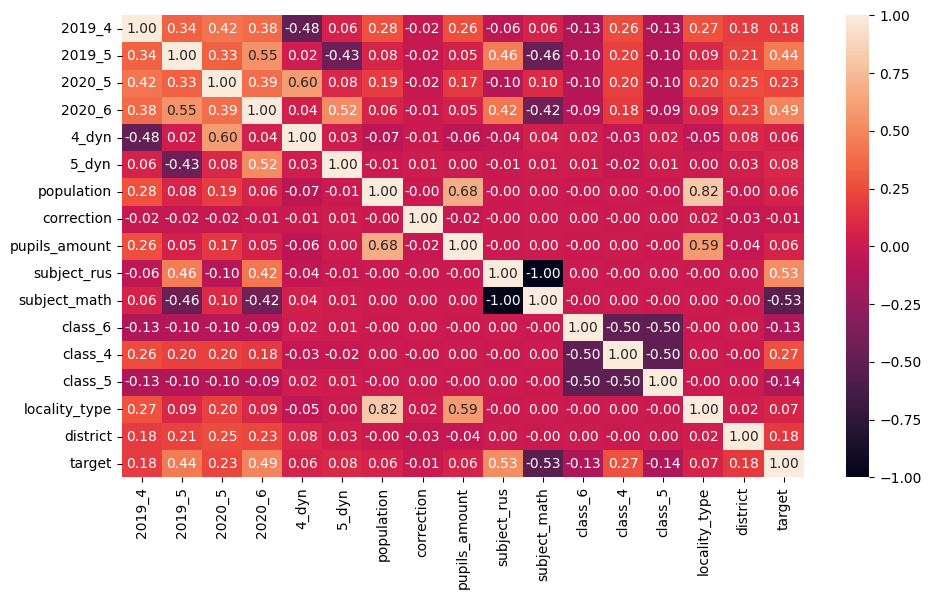

In [317]:
plot_heatmap(X_train_lr_aux.assign(target=y_train))

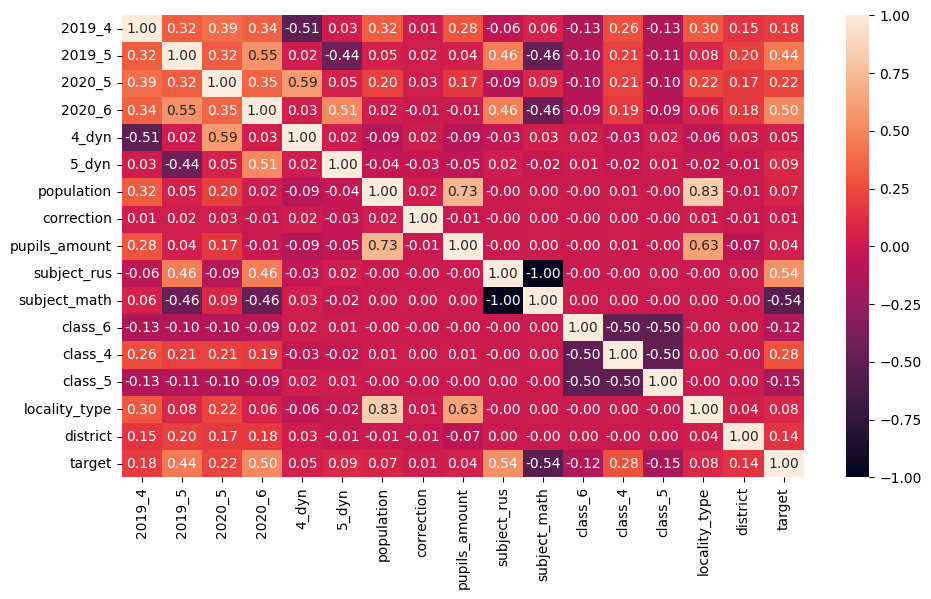

In [318]:
plot_heatmap(X_valid_lr_aux.assign(target=y_valid))

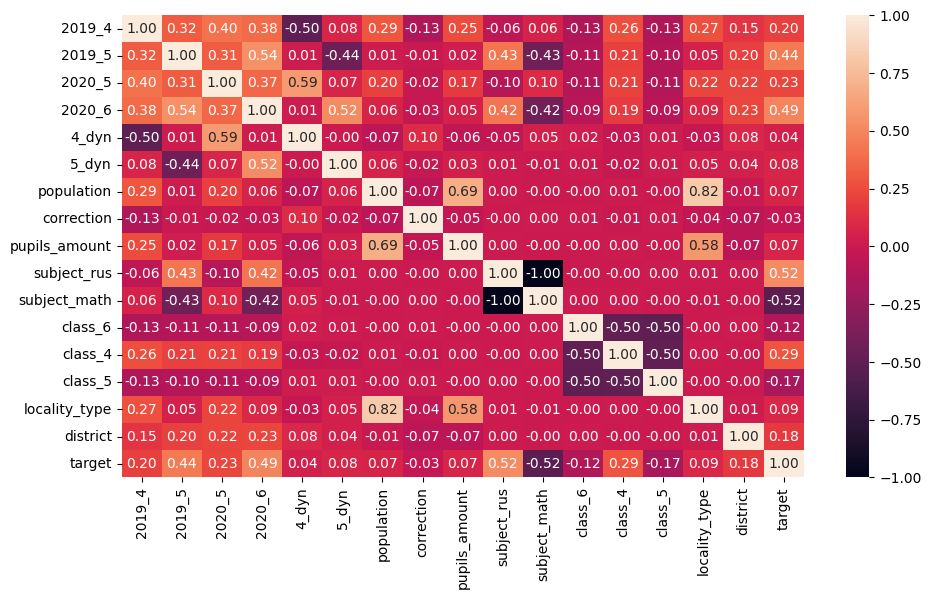

In [319]:
plot_heatmap(X_test_lr_aux.assign(target=y_test))

Видим, что во единственные сильно коррелирующие признаки - признаки того, что предмет является математикой или русским языком, поэтому один из них нужно удалить

In [320]:
X_train_lr_aux.drop(columns='subject_1', inplace=True)
X_valid_lr_aux.drop(columns='subject_1', inplace=True)
X_test_lr_aux.drop(columns='subject_1', inplace=True)

Создадим датасет для результатов работ моделей

In [321]:
linear_regression_results = pd.DataFrame({
    'Модель': [],
    'MSE на тестовой выборке': []
})

#### Обучение модели на всей выборке

In [322]:
linear_regression_params = {
    'model': {
        'type': 'categorical',
        'variants': ['Lasso', 'Ridge', 'ElasticNet'],
    },
    'alpha': {
        'type': 'float',
        'low': 1e-5,
        'high': 1e2,
        'log': True
    }
}

Модели линейной регрессии лучше подавать на вход данные одинакового масштаба, как как если масштабы у признаков будут сильно различаться, то чем больше будет масшатб, тем меньший вес будет у признака и сравнивать их важность будет некорректно, поэтому следует их все привести к одному масштабу

Сделать это можно с помощью MinMax-скейлинга - приведение значений в диапазон от 0 до 1

In [323]:
columns_to_scale = list(X_train_lr_aux.columns)
for column in ['subject_2', 'class_1', 'class_2', 'class_3', 'correction']:
    columns_to_scale.remove(column)

In [324]:
X_train_lr, X_valid_lr, X_test_lr = X_train_lr_aux.copy(), X_valid_lr_aux.copy(), X_test_lr_aux.copy()

In [325]:
min_max_scaler_global = MinMaxScaler()
min_max_scaler_global.fit(X_train_lr[columns_to_scale])
X_train_lr[columns_to_scale] = min_max_scaler_global.transform(X_train_lr[columns_to_scale])
X_valid_lr[columns_to_scale] = min_max_scaler_global.transform(X_valid_lr[columns_to_scale])
X_test_lr[columns_to_scale] = min_max_scaler_global.transform(X_test_lr[columns_to_scale])

In [326]:
study_linear_regression = optuna.create_study(direction='minimize', study_name='global_study_linear_regression')
study_linear_regression.optimize(lambda trial: objective(trial, linear_regression_params, None, mean_squared_error, X_train_lr, y_train, X_valid_lr, y_valid), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 10:55:41,723] A new study created in memory with name: global_study_linear_regression


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-15 10:55:41,777] Trial 0 finished with value: 0.546915939432268 and parameters: {'model': 'Ridge', 'alpha': 1.3257959589824968e-05}. Best is trial 0 with value: 0.546915939432268.
[I 2024-05-15 10:55:41,820] Trial 1 finished with value: 0.9904772028247911 and parameters: {'model': 'ElasticNet', 'alpha': 8.877312073627577}. Best is trial 0 with value: 0.546915939432268.
[I 2024-05-15 10:55:41,896] Trial 2 finished with value: 0.5469159394329566 and parameters: {'model': 'Ridge', 'alpha': 1.4561250025688574e-05}. Best is trial 0 with value: 0.546915939432268.
[I 2024-05-15 10:55:41,934] Trial 3 finished with value: 0.5475024243270843 and parameters: {'model': 'Ridge', 'alpha': 59.298240651194604}. Best is trial 0 with value: 0.546915939432268.
[I 2024-05-15 10:55:41,978] Trial 4 finished with value: 0.5469159419077458 and parameters: {'model': 'Ridge', 'alpha': 0.004689273277733692}. Best is trial 0 with value: 0.546915939432268.
[I 2024-05-15 10:55:41,998] Trial 5 finished wi

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.648e+02, tolerance: 2.876e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:43,159] Trial 18 finished with value: 0.5469123325883889 and parameters: {'model': 'Lasso', 'alpha': 1.1047653786337201e-05}. Best is trial 18 with value: 0.5469123325883889.
[I 2024-05-15 10:55:43,261] Trial 19 finished with value: 0.5492784010626025 and parameters: {'model': 'Lasso', 'alpha': 0.0035712924697918545}. Best is trial 18 with value: 0.5469123325883889.
[I 2024-05-15 10:55:43,559] Trial 20 finished with value: 0.54689490659603 and parameters: {'model': 'Lasso', 'alpha': 9.021379410953838e-05}. Best is trial 20 with value: 0.54689490659603.
[I 2024-05-15 10:55:43,890] Trial 21 finished with value: 0.5468972934380018 and parameters: {'model': 'Lasso', 'alpha': 7.910287147800795e-05}. Best is trial 20 with value: 0.54689490659603.
[I 2024-05-15 10:55:44,285] Trial 22 finished with value: 0.5468959921764249 and parameters: {'model': 'Lasso', 'alpha': 8.497515690511288e-05}. Best is trial 20 with value: 0.54689490659603.
[I 2024-05-15 10:55:44,614] Trial 23 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.015e+02, tolerance: 2.876e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:48,822] Trial 38 finished with value: 0.54690892573985 and parameters: {'model': 'Lasso', 'alpha': 2.5191852592946953e-05}. Best is trial 31 with value: 0.5468717276981584.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.017e+02, tolerance: 2.876e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:50,176] Trial 39 finished with value: 0.5469069865820843 and parameters: {'model': 'Lasso', 'alpha': 3.433173815572744e-05}. Best is trial 31 with value: 0.5468717276981584.
[I 2024-05-15 10:55:50,350] Trial 40 finished with value: 0.5468716550534413 and parameters: {'model': 'Lasso', 'alpha': 0.00042224939958047377}. Best is trial 40 with value: 0.5468716550534413.
[I 2024-05-15 10:55:50,515] Trial 41 finished with value: 0.5468700515568341 and parameters: {'model': 'Lasso', 'alpha': 0.00038286722511924183}. Best is trial 41 with value: 0.5468700515568341.
[I 2024-05-15 10:55:50,670] Trial 42 finished with value: 0.5468893563343744 and parameters: {'model': 'Lasso', 'alpha': 0.0005125162292260335}. Best is trial 41 with value: 0.5468700515568341.
[I 2024-05-15 10:55:50,778] Trial 43 finished with value: 0.5483468064741611 and parameters: {'model': 'Lasso', 'alpha': 0.0027132867886683824}. Best is trial 41 with value: 0.5468700515568341.
[I 2024-05-15 10:55:50,881] 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+02, tolerance: 2.876e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:52,664] Trial 49 finished with value: 0.5469045498682563 and parameters: {'model': 'Lasso', 'alpha': 4.431967460233836e-05}. Best is trial 41 with value: 0.5468700515568341.


In [327]:
best_linear_regression = linear_models_list[study_linear_regression.best_params['model']](**{key: value for key, value in study_linear_regression.best_params.items() if key != 'model'})
best_linear_regression.fit(X_train_lr, y_train)

Lasso(alpha=0.00038286722511924183)

In [328]:
linear_regression_mse = mean_squared_error(y_test, best_linear_regression.predict(X_test_lr))
linear_regression_results = pd.concat((linear_regression_results, pd.DataFrame([{'Модель': 'Линейная регрессия с регуляризацией на всей выборке', 'MSE на тестовой выборке': linear_regression_mse}])))
linear_regression_mse

0.5807820240820061

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


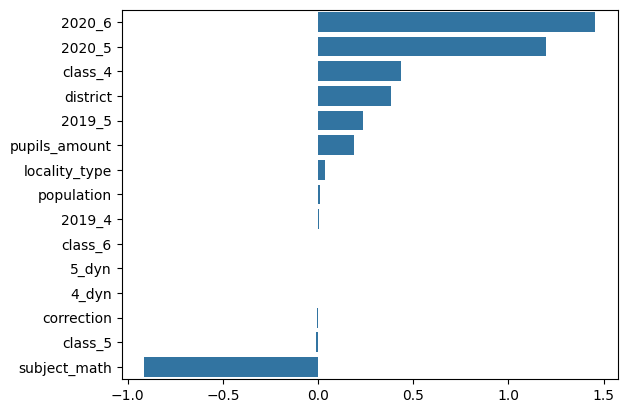

In [329]:
plot_feature_importances(best_linear_regression)

#### Разделение выборки по предметам и обучение на них моделей

In [330]:
X_train_lr_subjects = get_datasets(X_train_lr_aux, 'subject_2', columns_to_delete=['subject_2'])
X_valid_lr_subjects = get_datasets(X_valid_lr_aux, 'subject_2', columns_to_delete=['subject_2'])
X_test_lr_subjects = get_datasets(X_test_lr_aux, 'subject_2', columns_to_delete=['subject_2'])

In [331]:
X_train_lr_rus_aux, X_train_lr_math_aux = X_train_lr_subjects[0], X_train_lr_subjects[1]
X_valid_lr_rus_aux, X_valid_lr_math_aux = X_valid_lr_subjects[0], X_valid_lr_subjects[1]
X_test_lr_rus_aux, X_test_lr_math_aux = X_test_lr_subjects[0], X_test_lr_subjects[1]

In [332]:
if X_train_lr_rus_aux.index[0][-1] == 'h':
    X_train_lr_rus_aux, X_train_lr_math_aux = X_train_lr_math_aux, X_train_lr_rus_aux
    X_valid_lr_rus_aux, X_valid_lr_math_aux = X_valid_lr_math_aux, X_valid_lr_rus_aux
    X_test_lr_rus_aux, X_test_lr_math_aux = X_test_lr_math_aux, X_test_lr_rus_aux

##### Обучим модель предсказывать результаты по русскому языку и проинтерпретируем результаты

In [333]:
X_train_lr_rus, X_valid_lr_rus, X_test_lr_rus = X_train_lr_rus_aux.copy(), X_valid_lr_rus_aux.copy(), X_test_lr_rus_aux.copy()

In [334]:
min_max_scaler_rus = MinMaxScaler()
min_max_scaler_rus.fit(X_train_lr_rus_aux[columns_to_scale])
X_train_lr_rus[columns_to_scale] = min_max_scaler_rus.transform(X_train_lr_rus[columns_to_scale])
X_valid_lr_rus[columns_to_scale] = min_max_scaler_rus.transform(X_valid_lr_rus[columns_to_scale])
X_test_lr_rus[columns_to_scale] = min_max_scaler_rus.transform(X_test_lr_rus[columns_to_scale])

In [335]:
study_linear_regression_rus = optuna.create_study(direction='minimize', study_name='study_rus_linear_regression')
study_linear_regression_rus.optimize(lambda trial: objective(trial, linear_regression_params, None, mean_squared_error, X_train_lr_rus, y_train_rus, X_valid_lr_rus, y_valid_rus), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 10:55:53,346] A new study created in memory with name: study_rus_linear_regression


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-15 10:55:53,406] Trial 0 finished with value: 0.5978767591022676 and parameters: {'model': 'Ridge', 'alpha': 5.595402483963749}. Best is trial 0 with value: 0.5978767591022676.
[I 2024-05-15 10:55:53,440] Trial 1 finished with value: 0.5972171669952622 and parameters: {'model': 'Ridge', 'alpha': 1.841980744579289e-05}. Best is trial 1 with value: 0.5972171669952622.
[I 2024-05-15 10:55:53,465] Trial 2 finished with value: 0.5972752908575629 and parameters: {'model': 'Ridge', 'alpha': 0.5285719894197396}. Best is trial 1 with value: 0.5972171669952622.
[I 2024-05-15 10:55:53,506] Trial 3 finished with value: 0.59721755507173 and parameters: {'model': 'Ridge', 'alpha': 0.003575814573653419}. Best is trial 1 with value: 0.5972171669952622.
[I 2024-05-15 10:55:53,531] Trial 4 finished with value: 0.6094373321221173 and parameters: {'model': 'ElasticNet', 'alpha': 0.005368818191766278}. Best is trial 1 with value: 0.5972171669952622.
[I 2024-05-15 10:55:53,575] Trial 5 finished w

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e+02, tolerance: 1.436e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:55,835] Trial 40 finished with value: 0.5972452210480812 and parameters: {'model': 'ElasticNet', 'alpha': 2.9474103017690342e-05}. Best is trial 31 with value: 0.5972171660873037.
[I 2024-05-15 10:55:55,920] Trial 41 finished with value: 0.5972171665663478 and parameters: {'model': 'Ridge', 'alpha': 1.448784698964224e-05}. Best is trial 31 with value: 0.5972171660873037.
[I 2024-05-15 10:55:55,959] Trial 42 finished with value: 0.597217166252884 and parameters: {'model': 'Ridge', 'alpha': 1.161424771874338e-05}. Best is trial 31 with value: 0.5972171660873037.
[I 2024-05-15 10:55:55,992] Trial 43 finished with value: 0.5972171763210519 and parameters: {'model': 'Ridge', 'alpha': 0.0001039114444586659}. Best is trial 31 with value: 0.5972171660873037.
[I 2024-05-15 10:55:56,223] Trial 44 finished with value: 0.5972197266436633 and parameters: {'model': 'Lasso', 'alpha': 2.6325692721729045e-05}. Best is trial 31 with value: 0.5972171660873037.
[I 2024-05-15 10:55:56,3

In [336]:
best_linear_regression_rus = linear_models_list[study_linear_regression_rus.best_params['model']](**{key: value for key, value in study_linear_regression_rus.best_params.items() if key != 'model'})
best_linear_regression_rus.fit(X_train_lr_rus, y_train_rus)

Ridge(alpha=1.0096333302079881e-05)

In [337]:
linear_regression_rus_mse = mean_squared_error(y_test_rus, best_linear_regression_rus.predict(X_test_lr_rus))
linear_regression_results = pd.concat((linear_regression_results, pd.DataFrame([{'Модель': 'Линейная регрессия с регуляризацией, русский язык', 'MSE на тестовой выборке': linear_regression_rus_mse}])))
linear_regression_rus_mse

0.6522419652831523

In [338]:
linear_regression_rus_predictions = pd.DataFrame({
    'login': X_test_lr_rus.index,
    'predictions': denorm(best_linear_regression_rus.predict(X_test_lr_rus), y_train_rus_mean, y_train_rus_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


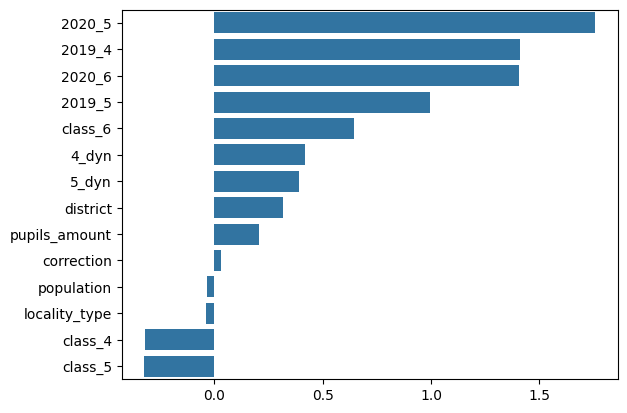

In [339]:
plot_feature_importances(best_linear_regression_rus)

Здесь самые важные признаки - средние баллы пяти- и шестиклассников за 2020 год, а также четверо- и пятиклассников за 2019 год и признак того, что ученик - шестиклассник

##### Обучим модель предсказывать результаты по математике и проинтерпретируем результаты

In [340]:
X_train_lr_math, X_valid_lr_math, X_test_lr_math = X_train_lr_math_aux.copy(), X_valid_lr_math_aux.copy(), X_test_lr_math_aux.copy()

In [341]:
min_max_scaler_math = MinMaxScaler()
min_max_scaler_math.fit(X_train_lr_math_aux[columns_to_scale])
X_train_lr_math[columns_to_scale] = min_max_scaler_math.transform(X_train_lr_math[columns_to_scale])
X_valid_lr_math[columns_to_scale] = min_max_scaler_math.transform(X_valid_lr_math[columns_to_scale])
X_test_lr_math[columns_to_scale] = min_max_scaler_math.transform(X_test_lr_math[columns_to_scale])

In [342]:
study_linear_regression_math = optuna.create_study(direction='minimize', study_name='study_math_linear_regression')
study_linear_regression_math.optimize(lambda trial: objective(trial, linear_regression_params, None, mean_squared_error, X_train_lr_math, y_train_math, X_valid_lr_math, y_valid_math), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 10:55:57,537] A new study created in memory with name: study_math_linear_regression


  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:57,874] Trial 0 finished with value: 0.39445594270081175 and parameters: {'model': 'Lasso', 'alpha': 1.270575698712195e-05}. Best is trial 0 with value: 0.39445594270081175.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.481e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:58,262] Trial 1 finished with value: 0.3944508537468128 and parameters: {'model': 'ElasticNet', 'alpha': 3.214510476433816e-05}. Best is trial 1 with value: 0.3944508537468128.
[I 2024-05-15 10:55:58,307] Trial 2 finished with value: 0.5728387916707799 and parameters: {'model': 'Lasso', 'alpha': 0.08002304650911034}. Best is trial 1 with value: 0.3944508537468128.
[I 2024-05-15 10:55:58,392] Trial 3 finished with value: 0.394586231844725 and parameters: {'model': 'Lasso', 'alpha': 0.0010148325018513819}. Best is trial 1 with value: 0.3944508537468128.
[I 2024-05-15 10:55:58,456] Trial 4 finished with value: 0.39602615392385965 and parameters: {'model': 'Lasso', 'alpha': 0.0025910715983436115}. Best is trial 1 with value: 0.3944508537468128.
[I 2024-05-15 10:55:58,495] Trial 5 finished with value: 0.9680921424991894 and parameters: {'model': 'Lasso', 'alpha': 86.1380582148446}. Best is trial 1 with value: 0.3944508537468128.
[I 2024-05-15 10:55:58,676] Trial 6 finish

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.904e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:59,250] Trial 11 finished with value: 0.39445716629108163 and parameters: {'model': 'ElasticNet', 'alpha': 1.2134636699115525e-05}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:55:59,310] Trial 12 finished with value: 0.3944623169683439 and parameters: {'model': 'Ridge', 'alpha': 0.0002273823116052172}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:55:59,358] Trial 13 finished with value: 0.5694347585153673 and parameters: {'model': 'ElasticNet', 'alpha': 0.09653620347353635}. Best is trial 6 with value: 0.3943874723991645.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:55:59,704] Trial 14 finished with value: 0.3944304057728228 and parameters: {'model': 'ElasticNet', 'alpha': 9.469390167700901e-05}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:55:59,739] Trial 15 finished with value: 0.3944623174637904 and parameters: {'model': 'Ridge', 'alpha': 0.00033574539782168665}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:55:59,800] Trial 16 finished with value: 0.41393410105028094 and parameters: {'model': 'ElasticNet', 'alpha': 0.012030793374426982}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:55:59,845] Trial 17 finished with value: 0.9680921424991894 and parameters: {'model': 'Lasso', 'alpha': 0.44393598976357207}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:56:00,166] Trial 18 finished with value: 0.39440416198738015 and parameters: {'model': 'ElasticNet', 'alpha': 0.00016145974438940653}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:56

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.668e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:00,661] Trial 21 finished with value: 0.39443617776544987 and parameters: {'model': 'ElasticNet', 'alpha': 7.639001752151215e-05}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:56:00,986] Trial 22 finished with value: 0.39440469984556015 and parameters: {'model': 'ElasticNet', 'alpha': 0.00016116677376855622}. Best is trial 6 with value: 0.3943874723991645.
[I 2024-05-15 10:56:01,336] Trial 23 finished with value: 0.39436953727408786 and parameters: {'model': 'ElasticNet', 'alpha': 0.00031982626303076606}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:01,558] Trial 24 finished with value: 0.3944134315299866 and parameters: {'model': 'ElasticNet', 'alpha': 0.0007615116309528627}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:01,660] Trial 25 finished with value: 0.41481535421604937 and parameters: {'model': 'ElasticNet', 'alpha': 0.012389579170075698}. Best is trial 23 with value: 0.39436953727408786.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.294e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:02,283] Trial 26 finished with value: 0.39444766693919225 and parameters: {'model': 'ElasticNet', 'alpha': 4.155569141462463e-05}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:02,505] Trial 27 finished with value: 0.3944899173734968 and parameters: {'model': 'ElasticNet', 'alpha': 0.0010269636394011608}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:02,606] Trial 28 finished with value: 0.39446233196484143 and parameters: {'model': 'Ridge', 'alpha': 0.0035045003331662904}. Best is trial 23 with value: 0.39436953727408786.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:03,860] Trial 29 finished with value: 0.39444951741169404 and parameters: {'model': 'Lasso', 'alpha': 2.5908156781919058e-05}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:03,985] Trial 30 finished with value: 0.5362312078022136 and parameters: {'model': 'Lasso', 'alpha': 0.038713798051822214}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:04,689] Trial 31 finished with value: 0.3943906193448203 and parameters: {'model': 'ElasticNet', 'alpha': 0.00021013248174712695}. Best is trial 23 with value: 0.39436953727408786.
[I 2024-05-15 10:56:05,210] Trial 32 finished with value: 0.39436908376690333 and parameters: {'model': 'ElasticNet', 'alpha': 0.00032693137981258354}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:05,597] Trial 33 finished with value: 0.39437037532724656 and parameters: {'model': 'ElasticNet', 'alpha': 0.00042132754816031563}. Best is trial 32 with value: 0.39436908376690333.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.519e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:06,863] Trial 34 finished with value: 0.3944514851681191 and parameters: {'model': 'ElasticNet', 'alpha': 3.028592059525714e-05}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:07,176] Trial 35 finished with value: 0.3943856787499978 and parameters: {'model': 'ElasticNet', 'alpha': 0.0006029800999926915}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:07,377] Trial 36 finished with value: 0.39464860968612814 and parameters: {'model': 'ElasticNet', 'alpha': 0.001387967907210211}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:07,870] Trial 37 finished with value: 0.3943693957745259 and parameters: {'model': 'ElasticNet', 'alpha': 0.00035371897244046793}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:07,987] Trial 38 finished with value: 0.40443261442493866 and parameters: {'model': 'ElasticNet', 'alpha': 0.007864124632459127}. Best is trial 32 with value: 0.39436908376690333.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.018e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:10,496] Trial 43 finished with value: 0.3944427541071972 and parameters: {'model': 'ElasticNet', 'alpha': 5.6232657937420704e-05}. Best is trial 32 with value: 0.39436908376690333.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.682e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:11,543] Trial 44 finished with value: 0.3944541564872423 and parameters: {'model': 'ElasticNet', 'alpha': 2.2430823501600814e-05}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:11,796] Trial 45 finished with value: 0.394369669945856 and parameters: {'model': 'ElasticNet', 'alpha': 0.00040293876255537945}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:11,924] Trial 46 finished with value: 0.3952721567965043 and parameters: {'model': 'ElasticNet', 'alpha': 0.0022203309449601617}. Best is trial 32 with value: 0.39436908376690333.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:12,462] Trial 47 finished with value: 0.3944262903522101 and parameters: {'model': 'ElasticNet', 'alpha': 0.00010814968717472616}. Best is trial 32 with value: 0.39436908376690333.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.896e+02, tolerance: 1.440e+00
  model = cd_fast.enet_coordinate_descent(


[I 2024-05-15 10:56:13,014] Trial 48 finished with value: 0.39445706308548173 and parameters: {'model': 'ElasticNet', 'alpha': 1.2485804066310395e-05}. Best is trial 32 with value: 0.39436908376690333.
[I 2024-05-15 10:56:13,122] Trial 49 finished with value: 0.3944623176336585 and parameters: {'model': 'Ridge', 'alpha': 0.0003728971167794028}. Best is trial 32 with value: 0.39436908376690333.


In [343]:
best_linear_regression_math = linear_models_list[study_linear_regression_math.best_params['model']](**{key: value for key, value in study_linear_regression_math.best_params.items() if key != 'model'})
best_linear_regression_math.fit(X_train_lr_math, y_train_math)

ElasticNet(alpha=0.00032693137981258354)

In [344]:
linear_regression_math_mse = mean_squared_error(y_test_math, best_linear_regression_math.predict(X_test_lr_math))
linear_regression_results = pd.concat((linear_regression_results, pd.DataFrame([{'Модель': 'Линейная регрессия с регуляризацией, математика', 'MSE на тестовой выборке': linear_regression_math_mse}])))
linear_regression_math_mse

0.40666551381793536

In [345]:
linear_regression_math_predictions = pd.DataFrame({
    'login': X_test_lr_math.index,
    'predictions': denorm(best_linear_regression_math.predict(X_test_lr_math), y_train_math_mean, y_train_math_std)
}).set_index('login')

<ipython-input-261-50c47d59b3c2>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  graphics.set(yticklabels=renamed_columns)


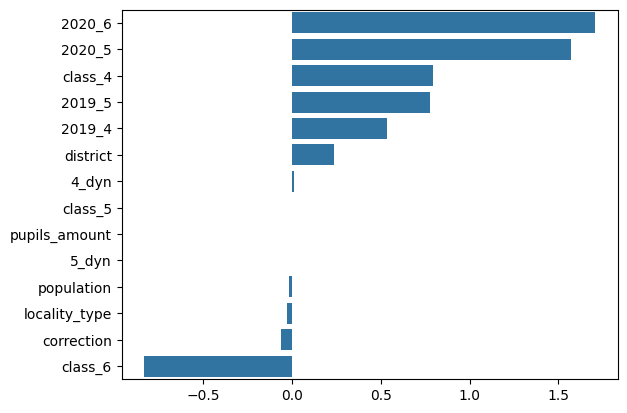

In [346]:
plot_feature_importances(best_linear_regression_math)

То же самое, что и в предыдущем пункте за ислючением того, что знак признака того, что ученик является шестиклассником - отрицательный

##### Теперь посчитаем MSE на всей выборке с использованием обученных моделей на выборках  с русским языком и математикой

In [347]:
linear_regression_predictions = pd.concat((linear_regression_rus_predictions, linear_regression_math_predictions))
linear_regression_predictions

predictions
login                          
sch33133202_5_rus      0.621209
sch59193506_6_rus      0.728277
sch59193293_5_rus      0.560545
sch54140007_5_rus      0.540084
sch66160168_4_rus      0.623357
...                         ...
sch35156065_5_math     0.495638
sch02123477_6_math     0.411959
sch50103084_6_math     0.455930
sch67173007_6_math     0.481693
sch08180084_4_math     0.575316

[3868 rows x 1 columns]

In [348]:
linear_regression_predictions['predictions'] = norm(linear_regression_predictions['predictions'], global_mean, global_std)

Посчитаем среднеквадратичную ошибку на всей выборке с помощью моделей, обученных на выборках по русскому языку и математике

In [349]:
linear_regression_mixed_mse = mean_squared_error(y_test.loc[linear_regression_predictions.index], linear_regression_predictions['predictions'])
linear_regression_results = pd.concat((linear_regression_results, pd.DataFrame([{'Модель': 'Линейная регресия с регуляризацией, русский язык + математика', 'MSE на тестовой выборке': linear_regression_mixed_mse}])))
linear_regression_mixed_mse

0.37192535172391844

##### Общие выводы

В целом, практически нет никаких отличий от моделей случайного леса и градиентного бустинга за исключеним того, что результаты получились хуже

#### Общие выводы по линейной регрессии

In [350]:
linear_regression_results = linear_regression_results.set_index('Модель')
linear_regression_results

MSE на тестовой выборке
Модель                                                                                
Линейная регрессия с регуляризацией на всей выборке                           0.580782
Линейная регрессия с регуляризацией, русский язык                             0.652242
Линейная регрессия с регуляризацией, математика                               0.406666
Линейная регресия с регуляризацией, русский язык + математика                 0.371925

Линейная регрессия демонстрирует здесь на удивление неплохие результаты, хоть они и немного похуже, чем те, которые демонстрируют "навороченные" случайный лес и градиентный бустинг

Здесь разделение на 2 выборки полностью оправдано - результат улучшился больше, чем на 2 десятых

### Метод ближайшего соседа

Ну раз уж на то пошло, то может попробовать максимально простой алгоритм, у которого нет даже фазы обучения, а все предсказания делаются только при вызове метода predict

Благо, что не нужны отдельные датасеты, ибо они будут такими же, как и для модели линейной регрессии

Создадим датасет для результатов работ моделей

In [351]:
knn_results = pd.DataFrame({
    'Модель': [],
    'MSE на тестовой выборке': []
})

#### Обучение модели на всей выборке

In [352]:
knn_params = {
    'n_neighbors': {
        'type': 'int',
        'low': 1,
        'high': 100,
        'log': True
    },
    'weights': {
        'type': 'categorical',
        'variants': ['uniform', 'distance']
    },
    'leaf_size': {
        'type': 'int',
        'low': 1,
        'high': 100,
        'log': True
    },
    'p': {
        'type': 'categorical',
        'variants': [1, 2]
    }
}

In [353]:
study_knn = optuna.create_study(direction='minimize', study_name='global_study_knn')
study_knn.optimize(lambda trial: objective(trial, knn_params, KNeighborsRegressor, mean_squared_error, X_train_lr, y_train, X_valid_lr, y_valid), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 10:56:13,885] A new study created in memory with name: global_study_knn


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-15 10:56:15,877] Trial 0 finished with value: 0.3335471752672831 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'leaf_size': 31, 'p': 2}. Best is trial 0 with value: 0.3335471752672831.
[I 2024-05-15 10:56:18,133] Trial 1 finished with value: 0.6484055516043301 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 1, 'p': 2}. Best is trial 0 with value: 0.3335471752672831.
[I 2024-05-15 10:56:20,389] Trial 2 finished with value: 0.6484055516043301 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 1, 'p': 2}. Best is trial 0 with value: 0.3335471752672831.
[I 2024-05-15 10:56:22,631] Trial 3 finished with value: 0.6424074240566217 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 5, 'p': 1}. Best is trial 0 with value: 0.3335471752672831.
[I 2024-05-15 10:56:26,804] Trial 4 finished with value: 0.33448804964679 and parameters: {'n_neighbors': 57, 'weights': 'uniform', 'leaf_size': 41, 'p': 1}. Best is trial 

In [354]:
best_knn = KNeighborsRegressor(**study_knn.best_params)
best_knn.fit(X_train_lr, y_train)

KNeighborsRegressor(leaf_size=24, n_neighbors=44, p=1, weights='distance')

In [355]:
knn_mse = mean_squared_error(y_test, best_knn.predict(X_test_lr))
knn_results = pd.concat((knn_results, pd.DataFrame([{'Модель': 'Метод ближайшего соседа на всей выборке', 'MSE на тестовой выборке': knn_mse}])))
knn_mse

0.36141600527503653

#### Разделим выборку по предметам и обучим на них модели

##### Обучим модели предсказывать результаты по русскому языку

In [356]:
study_knn_rus = optuna.create_study(direction='minimize', study_name='study_rus_knn')
study_knn_rus.optimize(lambda trial: objective(trial, knn_params, KNeighborsRegressor, mean_squared_error, X_train_lr_rus, y_train_rus, X_valid_lr_rus, y_valid_rus), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 10:59:03,051] A new study created in memory with name: study_rus_knn


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-15 10:59:03,532] Trial 0 finished with value: 0.7865261109131719 and parameters: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 11, 'p': 2}. Best is trial 0 with value: 0.7865261109131719.
[I 2024-05-15 10:59:03,856] Trial 1 finished with value: 1.1010775076710348 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 86, 'p': 2}. Best is trial 0 with value: 0.7865261109131719.
[I 2024-05-15 10:59:05,001] Trial 2 finished with value: 0.5808915260419899 and parameters: {'n_neighbors': 77, 'weights': 'distance', 'leaf_size': 4, 'p': 2}. Best is trial 2 with value: 0.5808915260419899.
[I 2024-05-15 10:59:06,818] Trial 3 finished with value: 0.5674476534955337 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'leaf_size': 3, 'p': 1}. Best is trial 3 with value: 0.5674476534955337.
[I 2024-05-15 10:59:07,866] Trial 4 finished with value: 1.0721196239836874 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 1, 'p': 1}. Best is tr

In [357]:
best_knn_rus = KNeighborsRegressor(**study_knn_rus.best_params)
best_knn_rus.fit(X_train_lr_rus, y_train_rus)

KNeighborsRegressor(leaf_size=15, n_neighbors=39, p=1, weights='distance')

In [358]:
knn_rus_mse = mean_squared_error(y_test_rus, best_knn_rus.predict(X_test_lr_rus))
knn_results = pd.concat((knn_results, pd.DataFrame([{'Модель': 'Метод ближайшего соседа, русский язык', 'MSE на тестовой выборке': knn_rus_mse}])))
knn_rus_mse

0.630715141460093

In [359]:
knn_rus_predictions = pd.DataFrame({
    'login': X_test_lr_rus.index,
    'predictions': denorm(best_knn_rus.predict(X_test_lr_rus), y_train_rus_mean, y_train_rus_std)
}).set_index('login')

##### Обучим модели предсказывать результаты по математике

In [360]:
study_knn_math = optuna.create_study(direction='minimize', study_name='study_math_knn')
study_knn_math.optimize(lambda trial: objective(trial, knn_params, KNeighborsRegressor, mean_squared_error, X_train_lr_math, y_train_math, X_valid_lr_math, y_valid_math), n_trials=50,
               show_progress_bar=True)

[I 2024-05-15 11:00:04,759] A new study created in memory with name: study_math_knn


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-05-15 11:00:05,380] Trial 0 finished with value: 0.3762923862819788 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'leaf_size': 13, 'p': 2}. Best is trial 0 with value: 0.3762923862819788.
[I 2024-05-15 11:00:05,875] Trial 1 finished with value: 0.5317717582288362 and parameters: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 28, 'p': 1}. Best is trial 0 with value: 0.3762923862819788.
[I 2024-05-15 11:00:06,802] Trial 2 finished with value: 0.38973226495010727 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'leaf_size': 5, 'p': 1}. Best is trial 0 with value: 0.3762923862819788.
[I 2024-05-15 11:00:07,579] Trial 3 finished with value: 0.44730792645910045 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 2, 'p': 2}. Best is trial 0 with value: 0.3762923862819788.
[I 2024-05-15 11:00:08,260] Trial 4 finished with value: 0.37161561883255634 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'leaf_size': 99, 'p': 1}. Best

In [361]:
best_knn_math = KNeighborsRegressor(**study_knn_math.best_params)
best_knn_math.fit(X_train_lr_math, y_train_math)

KNeighborsRegressor(leaf_size=88, n_neighbors=47, p=1, weights='distance')

In [362]:
knn_math_mse = mean_squared_error(y_test_math, best_knn_math.predict(X_test_lr_math))
knn_results = pd.concat((knn_results, pd.DataFrame([{'Модель': 'Метод ближайшего соседа, математика', 'MSE на тестовой выборке': knn_math_mse}])))
knn_math_mse

0.3955938020272292

In [363]:
knn_math_predictions = pd.DataFrame({
    'login': X_test_lr_math.index,
    'predictions': denorm(best_knn_math.predict(X_test_lr_math), y_train_math_mean, y_train_math_std)
}).set_index('login')

##### Теперь посчитаем MSE на всей выборке с использованием обученных моделей на выборках  с русским языком и математикой

In [364]:
knn_predictions = pd.concat((knn_rus_predictions, knn_math_predictions))
knn_predictions

predictions
login                          
sch33133202_5_rus      0.640893
sch59193506_6_rus      0.718299
sch59193293_5_rus      0.572874
sch54140007_5_rus      0.546966
sch66160168_4_rus      0.636892
...                         ...
sch35156065_5_math     0.516059
sch02123477_6_math     0.420763
sch50103084_6_math     0.454312
sch67173007_6_math     0.465947
sch08180084_4_math     0.566991

[3868 rows x 1 columns]

In [365]:
knn_predictions['predictions'] = norm(knn_predictions['predictions'], global_mean, global_std)

Посчитаем среднеквадратичную ошибку на всей выборке с помощью моделей, обученных на выборках по русскому языку и математике

In [366]:
knn_mixed_mse = mean_squared_error(y_test.loc[knn_predictions.index], knn_predictions['predictions'])
knn_results = pd.concat((knn_results, pd.DataFrame([{'Модель': 'Метод ближайшего соседа, русский язык + математика', 'MSE на тестовой выборке': knn_mixed_mse}])))
knn_mixed_mse

0.3605827379272554

#### Общие выводу по методу ближайших соседей

In [367]:
knn_results = knn_results.set_index('Модель')
knn_results

MSE на тестовой выборке
Модель                                                                     
Метод ближайшего соседа на всей выборке                            0.361416
Метод ближайшего соседа, русский язык                              0.630715
Метод ближайшего соседа, математика                                0.395594
Метод ближайшего соседа, русский язык + математика                 0.360583

Результаты получились сильно хуже, чем у предыдущих моделей. Очевидно, что модель в данном случае не может делать никаких предсказаний, используя только метрическую информацию (расстояния между объектами). То есть нужно что-то больше

Разделение на 2 выборки, кстати, помогло

### Нейронная сеть

Итак, пришла пора попробовать нейросетевой подход. Может быть он даст самый лучший результат

Определим процессор, на котором будет происходить обучение

In [368]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Создадим датасет для результатов работ моделей

In [369]:
nn_results = pd.DataFrame({
    'Модель': [],
    'MSE на тестовой выборке': []
})

Напишем класс для создания датасетов, которые будут использоваться при обучении

In [370]:
class NetworkDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return {
            'X': torch.as_tensor(self.X.iloc[index], dtype=torch.float32, device=device),
            'y': torch.as_tensor(self.y.iloc[index], dtype=torch.float32, device=device),
            'index': [self.X.index[index]]
        }

    def __len__(self):
        return self.X.shape[0]

Напишем функции для оценивания и тренировки модели

In [371]:
from tqdm.notebook import tqdm
from IPython.display import clear_output

In [372]:
def evaluate(model, loss_function, dataloader, desc, return_dataset=False):
    mean_loss, total_length = 0, 0
    predictions = pd.DataFrame()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=desc):
            logits = model(batch['X']).squeeze(dim=1)
            if return_dataset:
                predictions = pd.concat((predictions, pd.DataFrame({
                    'login': batch['index'][0],
                    'predictions': logits,
                }).set_index('login')))
            loss = loss_function(logits, batch['y'])
            mean_loss += loss.item() * batch['X'].shape[0]
            total_length += batch['X'].shape[0]

        if not return_dataset:
            mean_loss /= total_length
            return mean_loss
        return predictions

In [373]:
def train(model, optimizer, loss_function, train_dataloader, valid_dataloader, num_epochs, path_to_save_state, scheduler=None, desc='Evaluating model...'):
    train_losses, valid_losses = [], []
    min_valid_loss = None
    pbar = tqdm(range(1, num_epochs + 1))
    for epoch in pbar:
        pbar.set_description(f'Processing {epoch} epoch...')
        train_loss, train_length = 0, 0
        model.train()
        for batch in tqdm(train_dataloader, desc='Training model...'):
            optimizer.zero_grad()
            logits = model(batch['X']).squeeze(dim=1)
            loss = loss_function(logits, batch['y'])
            train_loss += loss.item() * batch['X'].shape[0]
            train_length += batch['X'].shape[0]
            loss.backward()
            optimizer.step()

        train_loss /= train_length
        train_losses.append(train_loss)

        if scheduler is not None:
            scheduler.step()

        model.eval()
        valid_loss = evaluate(model, loss_function, valid_dataloader, desc=desc)
        if min_valid_loss is None or min_valid_loss > valid_loss:
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), path_to_save_state)
        valid_losses.append(valid_loss)

        clear_output(wait=True)

        _, ax = plt.subplots()
        ax.plot(range(1, epoch + 1), train_losses, label='Train')
        ax.plot(range(1, epoch + 1), valid_losses, label='Valid')
        ax.set_title('Loss')
        ax.legend()
        ax.grid()
        plt.show()

Напишем функцию для создания простой двухслойной нейронной сети с батч-нормализацией для предотвращения регуляризаци и функцией активации ReLU, которая будет использоваться для обучения моделей

In [374]:
def create_nn(in_features, hidden_size):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=in_features, out_features=hidden_size),
        torch.nn.BatchNorm1d(num_features=hidden_size),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_size, out_features=1)
    )

#### Обучение модели на всей выборке

In [375]:
X_train_nn = NetworkDataset(X_train_lr, y_train)
X_valid_nn = NetworkDataset(X_valid_lr, y_valid)
X_test_nn = NetworkDataset(X_test_lr, y_test)

In [376]:
hidden_size = 1024
batch_size = 32

Создадим даталоадеры для модели

In [377]:
train_dataloader_nn = torch.utils.data.DataLoader(X_train_nn, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader_nn = torch.utils.data.DataLoader(X_valid_nn, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader_nn = torch.utils.data.DataLoader(X_test_nn, batch_size=batch_size, shuffle=True, drop_last=True)

Создадим модель и прочие вспомогательные атрибуты

In [378]:
nn_model = create_nn(X_train_lr.shape[1], hidden_size)

In [379]:
loss_function = torch.nn.MSELoss()
num_epochs = 20

In [380]:
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.85, step_size=5)
path_to_save_state = 'state'

Обучим модель

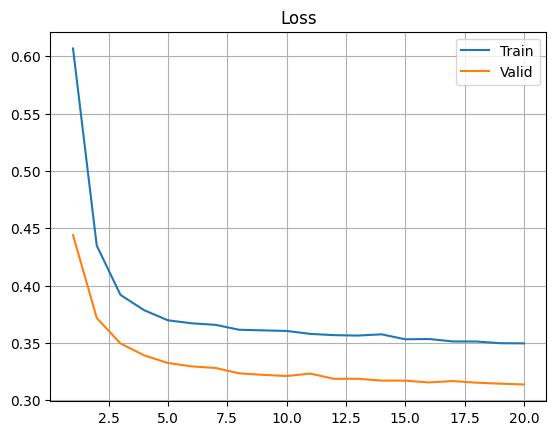

In [381]:
train(nn_model, optimizer, loss_function, train_dataloader_nn, valid_dataloader_nn, num_epochs, path_to_save_state, scheduler=scheduler)

In [382]:
nn_model.load_state_dict(torch.load(path_to_save_state))
nn_mse = evaluate(nn_model, loss_function, test_dataloader_nn, 'Evaluating model...')
nn_results = pd.concat((nn_results, pd.DataFrame([{'Модель': 'Нейронная сеть на всей выборке', 'MSE на тестовой выборке': nn_mse}])))
nn_mse

Evaluating model...:   0%|          | 0/121 [00:00<?, ?it/s]

0.3424618092539885

#### Разделим выборку по предметам и обучим на них модели

#### Разделим выборку по предметам и обучим на них модели

##### Обучим модель предсказывать результаты по русскому языку



In [383]:
X_train_nn_rus = NetworkDataset(X_train_lr_rus, y_train_rus)
X_valid_nn_rus = NetworkDataset(X_valid_lr_rus, y_valid_rus)
X_test_nn_rus = NetworkDataset(X_test_lr_rus, y_test_rus)

In [384]:
hidden_size = 1024
batch_size = 32

Создадим даталоадеры для модели

In [385]:
train_dataloader_nn_rus = torch.utils.data.DataLoader(X_train_nn_rus, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader_nn_rus = torch.utils.data.DataLoader(X_valid_nn_rus, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader_nn_rus = torch.utils.data.DataLoader(X_test_nn_rus, batch_size=batch_size, shuffle=True, drop_last=True)

Создадим модель и прочие вспомогательные атрибуты

In [386]:
nn_rus_model = create_nn(X_train_lr_rus.shape[1], hidden_size)

In [387]:
loss_function = torch.nn.MSELoss()
num_epochs = 20

In [388]:
optimizer = torch.optim.AdamW(nn_rus_model.parameters(), lr=1e-5)
path_to_save_state = 'state'

Обучим модель

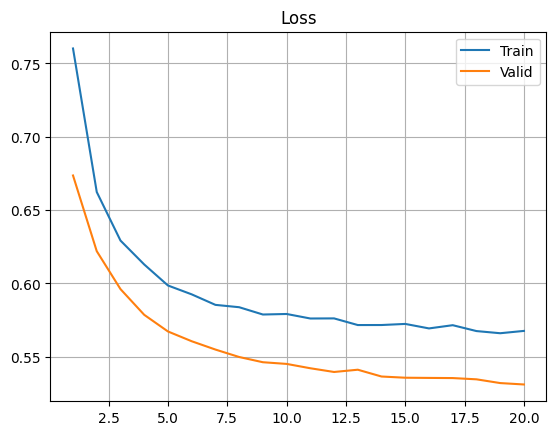

In [389]:
train(nn_rus_model, optimizer, loss_function, train_dataloader_nn_rus, valid_dataloader_nn_rus, num_epochs, path_to_save_state)

In [390]:
nn_rus_model.load_state_dict(torch.load(path_to_save_state))
nn_rus_mse = evaluate(nn_rus_model, loss_function, test_dataloader_nn_rus, 'Evaluating model...')
nn_results = pd.concat((nn_results, pd.DataFrame([{'Модель': 'Нейронная сеть, русский язык', 'MSE на тестовой выборке': nn_rus_mse}])))
nn_rus_mse

Evaluating model...:   0%|          | 0/61 [00:00<?, ?it/s]

0.6025227348641776

In [391]:
nn_rus_predictions = evaluate(nn_rus_model, loss_function, test_dataloader_nn_rus, 'Evaluating model...', return_dataset=True)
nn_rus_predictions['predictions'] = denorm(nn_rus_predictions['predictions'], y_train_rus_mean, y_train_rus_std)

Evaluating model...:   0%|          | 0/61 [00:00<?, ?it/s]

##### Обучим модель предсказывать результаты по математике

In [392]:
X_train_nn_math = NetworkDataset(X_train_lr_math, y_train_math)
X_valid_nn_math = NetworkDataset(X_valid_lr_math, y_valid_math)
X_test_nn_math = NetworkDataset(X_test_lr_math, y_test_math)

In [393]:
hidden_size = 1024
batch_size = 32

Создадим даталоадеры для модели

In [399]:
train_dataloader_nn_math = torch.utils.data.DataLoader(X_train_nn_math, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader_nn_math = torch.utils.data.DataLoader(X_valid_nn_math, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader_nn_math = torch.utils.data.DataLoader(X_test_nn_math, batch_size=batch_size, shuffle=True, drop_last=True)

Создадим модель и прочие вспомогательные атрибуты

In [400]:
nn_math_model = create_nn(X_train_lr_math.shape[1], hidden_size)

In [401]:
loss_function = torch.nn.MSELoss()
num_epochs = 20

In [402]:
optimizer = torch.optim.AdamW(nn_math_model.parameters(), lr=1e-5)
path_to_save_state = 'state'

Обучим модель

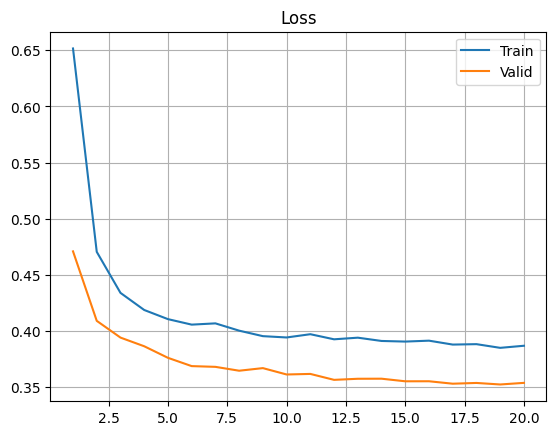

In [403]:
train(nn_math_model, optimizer, loss_function, train_dataloader_nn_math, valid_dataloader_nn_math, num_epochs, path_to_save_state)

In [404]:
nn_math_model.load_state_dict(torch.load(path_to_save_state))
nn_math_mse = evaluate(nn_math_model, loss_function, test_dataloader_nn_math, 'Evaluating model...')
nn_results = pd.concat((nn_results, pd.DataFrame([{'Модель': 'Нейронная сеть, математика', 'MSE на тестовой выборке': nn_math_mse}])))
nn_math_mse

Evaluating model...:   0%|          | 0/59 [00:00<?, ?it/s]

0.376523088853238

In [405]:
nn_math_predictions = evaluate(nn_math_model, loss_function, test_dataloader_nn_math, 'Evaluating model...', return_dataset=True)
nn_math_predictions['predictions'] = denorm(nn_math_predictions['predictions'], y_train_math_mean, y_train_math_std)

Evaluating model...:   0%|          | 0/59 [00:00<?, ?it/s]

##### Теперь посчитаем MSE на всей выборке с использованием обученных моделей на выборках  с русским языком и математикой

In [406]:
nn_predictions = pd.concat((nn_rus_predictions, nn_math_predictions))
nn_predictions

predictions
login                          
sch50106046_4_rus      0.673095
sch09193089_6_rus      0.652488
sch34143612_5_rus      0.530026
sch50103554_4_rus      0.674399
sch23133858_6_rus      0.675001
...                         ...
sch55150138_6_math     0.380242
sch70103136_5_math     0.441473
sch38183132_6_math     0.350762
sch78180389_6_math     0.434058
sch70103183_6_math     0.360176

[3837 rows x 1 columns]

In [407]:
nn_predictions['predictions'] = norm(nn_predictions['predictions'], global_mean, global_std)

Посчитаем среднеквадратичную ошибку на всей выборке с помощью моделей, обученных на выборках по русскому языку и математике

In [408]:
mean_squared_error(X_test_nn.y.loc[nn_predictions.index], nn_predictions['predictions'])

0.3444609604502524

In [409]:
nn_mixed_mse = mean_squared_error(X_test_nn.y.loc[nn_predictions.index], nn_predictions['predictions'])
nn_results = pd.concat((nn_results, pd.DataFrame([{'Модель': 'Нейронная сеть, русский язык + математика', 'MSE на тестовой выборке': nn_mixed_mse}])))
nn_mixed_mse

0.3444609604502524

#### Общие выводы по нейронной сети

In [410]:
nn_results = nn_results.set_index('Модель')
nn_results

MSE на тестовой выборке
Модель                                                            
Нейронная сеть на всей выборке                            0.342462
Нейронная сеть, русский язык                              0.602523
Нейронная сеть, математика                                0.376523
Нейронная сеть, русский язык + математика                 0.344461

Нейронные сети обучаются долго (по крайней мере дольше, чем алгоритмы классического машинного обучения), и наша задача - не исключение

Однако случайный лес и градиентный бустинг при меньшем времени обучения демонстируют лучшие результаты, поэтому скорее всего для основной задачи я выберу градиентный бустинг

## Подведём итоги

In [411]:
def return_combined_results(index):
    return pd.DataFrame({
        'Модель': [random_forest_results.index[index], catboost_results.index[index], linear_regression_results.index[index], knn_results.index[index],
                   nn_results.index[index]],
        'MSE на тестовой выборке': [random_forest_results.values[index][0], catboost_results.values[index][0], linear_regression_results.values[index][0],
                                    knn_results.values[index][0], nn_results.values[index][0]]
    }).set_index('Модель').sort_values(by='MSE на тестовой выборке')

In [412]:
whole_sample_results = return_combined_results(0)
rus_sample_results = return_combined_results(1)
math_sample_results = return_combined_results(2)
rus_and_math_sample_results = return_combined_results(3)

In [413]:
whole_sample_results

MSE на тестовой выборке
Модель                                                                      
Градиентный бустинг на всей выборке                                 0.339208
Нейронная сеть на всей выборке                                      0.342462
Случайный лес на всей выборке                                       0.346428
Метод ближайшего соседа на всей выборке                             0.361416
Линейная регрессия с регуляризацией на всей выборке                 0.580782

In [414]:
rus_sample_results

MSE на тестовой выборке
Модель                                                                    
Градиентный бустинг, русский язык                                 0.594926
Нейронная сеть, русский язык                                      0.602523
Случайный лес, русский язык                                       0.602796
Метод ближайшего соседа, русский язык                             0.630715
Линейная регрессия с регуляризацией, русский язык                 0.652242

In [415]:
math_sample_results

MSE на тестовой выборке
Модель                                                                  
Градиентный бустинг, математика                                 0.372382
Нейронная сеть, математика                                      0.376523
Случайный лес, математика                                       0.383708
Метод ближайшего соседа, математика                             0.395594
Линейная регрессия с регуляризацией, математика                 0.406666

In [416]:
rus_and_math_sample_results

MSE на тестовой выборке
Модель                                                                                
Градиентный бустинг, русский язык + математика                                0.339818
Нейронная сеть, русский язык + математика                                     0.344461
Случайный лес, русский язык + математика                                      0.346854
Метод ближайшего соседа, русский язык + математика                            0.360583
Линейная регресия с регуляризацией, русский язык + математика                 0.371925

Как видим, на каждый из четырёх результатов модели располагаются в следующем порядке по увеличению MSE на тестовой выборке:

1) Градиентный бустинг

2) Случайный лес

3) Нейронная сеть

4) Линейная регрессия

5) Метод ближайшего соседа

Несмотря на то, что лучшая модель (градиентный бустинг) обучается достаточно долго (по сравнению с той же линейной регрессией), для последующих обучений я возьму именно градиентный бустинг